In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import re
import time
import cv2
import random
import math
from keras.datasets import mnist

Using TensorFlow backend.
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym o

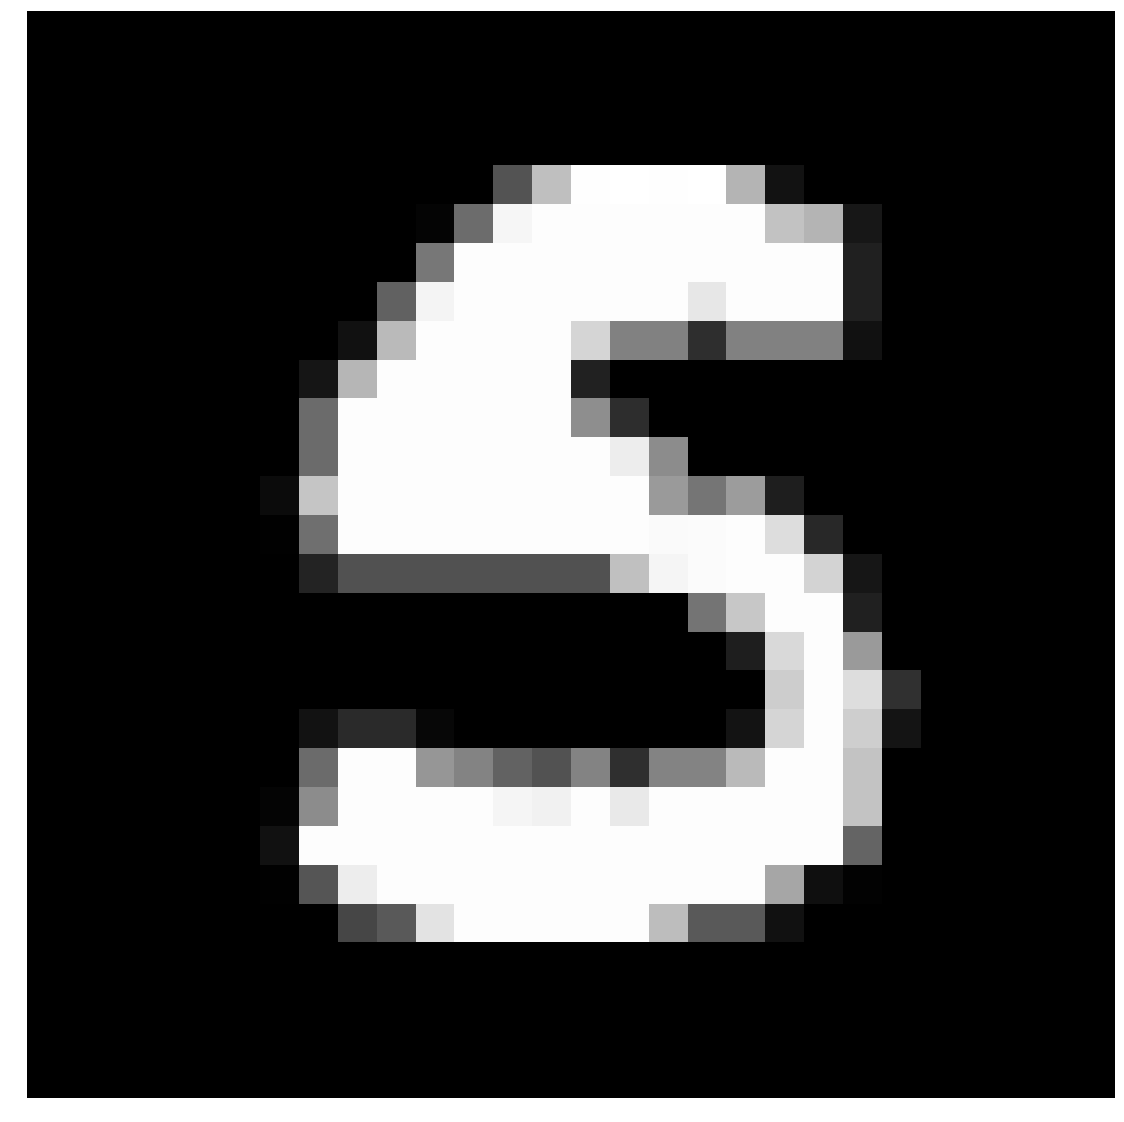

In [2]:
def disp(X):
    fig, ax=plt.subplots(1,1,figsize=(20,20))
    ax.imshow(X)
    ax.axis('off')
    plt.show()

(trainX, trainy), (testX, testy) = mnist.load_data()
zz=trainX[1997]
zz=zz.reshape(zz.shape[0], zz.shape[1], 1)
zz1=zz.copy()

zz=np.append(zz, zz1, axis=2)
zz=np.append(zz, zz1, axis=2)
zz=zz/255
disp(zz)
#print(zz.dtype, type(zz))

In [11]:
#Tworzę większą tablicę zer i "wkładam" w nią X - array
def my_pad(X, a, b, c, d):    
    Y=np.zeros((X.shape[0]+b+d, X.shape[1]+a+c, X.shape[2]), dtype='float64')
    Y[b:X.shape[0]+b,a:X.shape[1]+a,:]=X
    return Y

#Konwolucja w przód
def conv_forw(X, mat):
    Z=np.zeros((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            Z=Z+ff
    return Z

#Konwolucja w tył
def conv_back(X, mat, Der):
    Z=np.ndarray((X.shape[0], X.shape[1], X.shape[2]), dtype='float64')
    matd=mat*0
    Z=Z*0
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*Der
            Z[i:Der.shape[0]+i,j:Der.shape[1]+j]=Z[i:Der.shape[0]+i,j:Der.shape[1]+j]+ff
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            matd[i,j]=sum(sum(sum(np.multiply(ff, Der))))
    return (Z, matd)

#Relu za konwolucją
def relu(X):
    Y=X.copy()
    Y[Y<0]=0
    return Y

def relu_back(X, Der):
    Sd=Der.copy()
    Sd[X<0.0000001]=0
    return Sd

#Pooling (dodaje odpowiedni padding przed transformacją)
def pool_forw(X, mat):
    t1=(mat[0]-X.shape[0]%mat[0])%mat[0]
    t2=(mat[1]-X.shape[1]%mat[1])%mat[1]
    
    Y=my_pad(X, t2//2, t1//2, (t2//2+t2%2), t1//2+t1%2)
    silver_in_blood=np.asarray([[0]*(Y.shape[1]//mat[1])]*(Y.shape[0]//mat[0]))
    
    Exit=np.zeros(Y.shape, dtype='float64')
    Exit=Exit[:(Exit.shape[0]//mat[0]),:(Exit.shape[1]//mat[1])]
    
    Truth=np.zeros(Y.shape, dtype='int64')
    Truth2=np.zeros(Y.shape, dtype='int64')
    Pure=np.zeros(Y.shape, dtype='float64')
    
    Truth=Truth[:(Truth.shape[0]//mat[0]),:(Truth.shape[1]//mat[1])]
    Truth2=Truth2[:(Truth2.shape[0]//mat[0]),:(Truth2.shape[1]//mat[1])]
    
    for i in range(mat[0]):
        for j in range(mat[1]):
            Bleeding_One=Y[list(range(i, Y.shape[0], mat[0]))][:,list(range(j, Y.shape[1], mat[1]))]
            #Bleeding_One=Y[np.ix_(list(range(0, Y.shape[0], mat[0])),list(range(0, Y.shape[1], mat[1])))]
            
            Truth[Exit<Bleeding_One]=i
            Truth2[Exit<Bleeding_One]=j
            Exit[Exit<Bleeding_One]=Bleeding_One[Exit<Bleeding_One]
    
    for i in range(Truth.shape[0]):
        for j in range(Truth.shape[1]):
            for ij in range(Truth.shape[2]):
                Pure[i*mat[0]+Truth[i,j,ij],j*mat[1]+Truth2[i,j,ij],ij]=1
    return (Exit, Pure)

#Pooling w tył
def pool_back(X, mat, dim):
    Y=np.ndarray((X.shape[0]*mat[0], X.shape[1]*mat[1], X.shape[2]), dtype='float64')
    
    for i in range(mat[0]):
        for j in range(mat[1]):
            Y[np.ix_(np.asarray(list(range(i,Y.shape[0],mat[0]))),np.asarray(list(range(j,Y.shape[1],mat[1]))))]=X
    Y=Y*dim
    return Y


def sigmoid(x):
    try:
        s=1/(1+math.exp(-x))
        return s
    except:
        return 0
    
def sigmoid_forw(v):
    return np.asmatrix(np.apply_along_axis(sigmoid, 1, v).reshape(v.shape[0], 1))

def sigmoid_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: sigmoid(x)*(1-sigmoid(x)), 1, v).reshape(v.shape[0], 1))

def rell_forw(v):
    return np.asmatrix(np.apply_along_axis(lambda x: max(0.0, x), 1, v).reshape(v.shape[0], 1))

def rell_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: np.sign(max(0.0, x)), 1, v).reshape(v.shape[0], 1))

def cost(act, pred):
    summ=0
    der=pred*0
    
    for i in range(pred.shape[0]):        
        if ((pred[i,0]==0 and act[i,0]==0) or (pred[i,0]==1 and act[i,0]==1)):
            der[i,0]=0
        else:
            if (pred[i,0]<0.000001):
                pred[i,0]=0.000001
            elif(pred[i,0]>0.99999):
                pred[i,0]=0.99999
            der[i,0]=-act[i,0]/pred[i,0]+(1-act[i,0])/(1-pred[i,0])
        
        if (pred[i,0]<0.000001):
            pred[i,0]=0.000001
        elif(pred[i,0]>0.99999):
            pred[i,0]=0.99999
        
        summ=summ-act[i,0]*math.log(pred[i,0])-(1-act[i,0])*math.log(1-pred[i,0])
        
    return (der, summ)

#ccn - learning rate, loopz - number of iterations, streetcleaner - hardcoded number of weights in first Fully connected layer
ccn=0.02
loopz=60000
streetcleaner=1690

matt=[0]*10
matt2=[0]*10
for i in range(10):
    matt[i]=np.asarray([np.random.normal(0, 0.4) for j in range(9)]).reshape(3,3)
    matt2[i]=np.asarray([np.random.normal(0, 0.4) for j in range(9)]).reshape(3,3)

#img=cv2.imread("E:\W3\GGHard.jpg")
w1=np.asmatrix(np.asarray([np.random.normal(0, 0.4) for j in range(streetcleaner*20)]).reshape(20,streetcleaner))
#bw1=np.random.normal(0, 0.4)
w2=np.asmatrix(np.asarray([np.random.normal(0, 0.4) for j in range(10*20)]).reshape(10,20))
#bw2=np.random.normal(0, 0.4)

m2=[0]*10
m3=[0]*10
m4=[0]*10
m5=[0]*10
m6=[0]*10
m7=[0]*10
m8=[0]*10
mtb2=[0]*10
mtb3=[0]*10
mtb4=[0]*10
mtb5=[0]*10
mtb6=[0]*10
mtb7=[0]*10
mtb8=[0]*10


sk=[0]*loopz
t1=time.time()
for jj in range(loopz):
    img=trainX[jj]
    img=img/255
    img=img.reshape(img.shape[0], img.shape[1], 1)
    
    #Forw - Konwolucja, Relu, Pooling
    
    for i in range(10):
        m2[i]=conv_forw(img, matt[i])
        m3[i]=relu(m2[i])
        m4[i], Face1=pool_forw(m3[i], (2,2))
        m8[i]=m4[i].reshape(m4[i].shape[0]*m4[i].shape[1]*m4[i].shape[2])
    

    #Forw - 2*FC na macierzach
    kk=np.asarray(m8)
    m9=np.asmatrix(kk.reshape(kk.shape[0]*kk.shape[1], 1))
    #print(len(m9))

    s1=w1*m9#+bw1
    #s2=sigmoid_forw(s1)
    s2=rell_forw(s1)
    s3=w2*s2#+bw2
    s4=sigmoid_forw(s3)
    
    
    #Koszt
    dp=np.asarray([0]*10).reshape(10, 1)
    dp[trainy[jj],0]=1
    der, suma=cost(dp, s4)
    sk[jj]=suma
    print(suma)
    
    #Back - 2.FC
    dk2=np.asmatrix(np.asarray(sigmoid_back(s3))*np.asarray(der))
    weight_delta2=dk2*s2.T
    #bw2_delta=sum(dk2)[0,0]
    dk1=w2.T*dk2

    #Back - 1.FC
    #dk1=np.asmatrix(np.asarray(sigmoid_back(s1))*np.asarray(dk1))
    dk1=np.asmatrix(np.asarray(rell_back(s1))*np.asarray(dk1))
    weight_delta1=dk1*m9.T
    #bw1_delta=sum(dk1)[0,0]
    dk0=w1.T*dk1
    

    #Back - 2*Konw, RElu, Pooling
    #dkl=np.asarray(dk0).reshape(10, m7[0].shape[0], m7[0].shape[1], m7[0].shape[2])
    dkl=np.asarray(dk0).reshape(10, m4[0].shape[0], m4[0].shape[1], m4[0].shape[2])
    
    
    for i in range(10):
        #mtb5[i]=pool_back(mtb6[i], (2,2), Face1)
        mtb5[i]=pool_back(dkl[i], (2,2), Face1)
        cz=m3[i].shape
        nw=mtb5[i].shape
        mtb5[i]=mtb5[i][(nw[0]-cz[0])//2:cz[0]+(nw[0]-cz[0])//2, (nw[1]-cz[1])//2:cz[1]+(nw[1]-cz[1])//2]
        mtb4[i]=relu_back(m3[i], mtb5[i])
        mtb3[i], Dr=conv_back(img, matt[i], mtb4[i])

    w1-=weight_delta1*ccn
    #bw1-=bw1_delta*ccn*0.1
    w2-=weight_delta2*ccn
    #bw2-=bw2_delta*ccn*0.05
    matt-=Dr*ccn
    #matt2-=Dr2*ccn
    

t2=time.time()
print(t2-t1)
print(s4)

14.858094116562189
42.526919956424386
32.408762644714685
14.8294070215309
13.057962786539163
18.507392577470515
14.026675935437108
25.594905723285866
4.8017311365456345
7.804019437704079
18.852244038049704
7.514486677103056
1.3095757703927047
17.65067272561559
0.5123916683142817
12.254144450114758
14.90068256251289
7.408148473313781
3.926178051237439
5.591756851920124
4.32899509172724
7.205320054435879
6.246949263546808
2.314617376431704
4.23313200802242
9.054556058504339
5.105214231061455
10.827844444280796
8.92979639885617
6.9647670676949405
4.205360689517419
5.727780543258478
5.060373685478616
3.2515236654137807
2.3960895627920777
4.368749761541051
6.931471805599453
2.8196096250155334
4.889768882149044
3.070394889011235
4.736121959661446
3.718522435766067
3.066598199124939
4.737613317616919
4.802828083701923
2.910060486663215
3.213584755470597
4.308015633426183
3.7467096867290195
3.6789157472493152
1.904191232281672
1.1139778309127575
7.008132426681462
5.523325478358035
3.8076644212

3.363869120077287
3.6295308548661636
7.441009587758399
0.2556847274230413
2.7336408236715184
0.9892400219636684
0.2670380864056472
1.8588877006755509
3.541630207322369
0.2460743274360451
0.37367696170626463
0.11398070538974128
4.639969691420012
4.270597365284641
0.2844568261004016
1.3442520822319504
5.290356685426303
0.20630611877936866
0.5449604555419874
4.215516008637721
0.058676974852678976
1.5643904609950328
0.15566169708851293
1.1155413667327858
0.3625576310581519
4.09040620801049
1.8131444029253083
2.5553393855396025
4.80603455599284
0.38304888617292693
2.184370125209
2.533899837052632
3.143285197767656
1.732580196773986
3.5964977970333853
2.497015760728123
2.438963960298495
0.13590807300642013
2.432416418066337
0.09859715137633364
0.4586093185713576
3.7379896946500333
1.3374512256595155
2.3580240384723137
9.709812428376111
0.2527490043741472
2.2411910538740125
4.027869326041849
0.046405697639633404
3.193779426942064
14.127242026305204
3.1480712533121866
5.016611921272974
2.52536

0.3509968565168122
0.0778801813341424
3.5837097821618014
6.440849548969158
3.0951632557638264
0.6908969877430371
11.982915178315954
1.1657463078725663
0.8787713705648332
0.24017019782435228
1.9946304013161047
1.4416582613201108
0.6494222461815521
1.4292467056755922
0.5449202887954706
0.0999432546803743
4.940650433943759
3.337758541792587
0.1155058940170971
3.1867916574732043
4.383292030760833
0.6587144723805844
1.708035303901892
0.4206635235443458
0.3357609546888931
2.6439286632485186
2.2741496248757374
2.181518529086792
0.49448924316956305
1.546673488784156
0.14483506577992095
0.7017758861666133
0.2489748323382957
3.7967827940027985
2.492465429390139
2.0012459105913263
1.987800612388494
6.061328808092563
0.19357048487361186
4.163250274820436
1.062143436053704
0.6897061723693465
3.154160426750399
3.1375573575778963
2.0422550824402546
0.19722870147931393
0.060630864181490524
4.503377380956682
0.13732733292387808
0.9191893371005608
4.2534759097925265
3.6084131105336965
1.150878789448496


0.02172752833775728
0.015779038004486778
1.9959578695927465
3.0008678306033403
0.41897231046419964
3.296520393667355
0.09724621944508244
1.267775719873756
5.196083704751904
1.7766456307037135
6.326238862770057
1.4707770988499347
0.03362214076106114
3.3438208030574863
1.8968158160631605
4.713974365156368
0.19586113373395753
2.578095712810587
0.6682589333477383
2.1589055762085176
0.7985385019568728
7.930663349175143
0.09585749018033594
1.5907086078419297
3.020198671917859
3.0625400407266943
1.86673400009276
0.18706657067693752
0.23479415280794683
4.669060754224355
2.5597309674719515
4.418782707546452
1.141424349834097
4.108822142591076
0.8615071470854946
0.43430972731589196
0.1118535676891046
0.03759846284627583
0.06661485324773969
1.5935443975266739
0.15898070505943873
0.007109551123588197
1.5400909887981276
4.042983660952985
0.5406080556048953
4.923834616599279
0.7248424670875651
2.9853160964501777
0.15904586622689332
1.1232720643752312
0.23371654839687078
3.226409276687784
1.366931466

0.1411160041832083
1.9108236343847347
0.17341159440463433
7.909140017825674
3.183199088139076
0.7071493751083073
0.015803424558578878
1.9404961289588263
0.8666225009070649
0.6263256320956959
0.023865690308769425
1.5502014480274733
0.008552269447792249
4.45782840232259
0.20495422188429782
14.431871090741664
3.6392185438254963
2.0964938288291464
0.0821406273584125
1.8360936594908324
0.34464260795383117
3.021338666949984
2.7498115191230657
0.01142128300080934
0.9170764258474103
5.382758901132522
0.07713167308965847
0.21908281782731856
0.3981442000959176
0.845920390226411
1.4835494314951616
1.444552244066182
0.03734480101914702
0.014140073253980513
0.4049654890913774
1.880234565919673
0.9192889800047483
4.5521030498877115
0.029811217488558205
0.8919902184554842
0.7154947781865545
0.34167192089733495
1.6116875098640189
2.310608129582251
1.8829129639107722
1.9036723541173814
0.215189431438098
0.0762561016438072
0.041672339625797646
0.915308425324102
0.27179655497088445
2.1276103411054477
2.7

0.003543201620021778
0.10857073227114991
0.21795842076060543
1.7009698146080283
3.596819616927541
0.3947930193449915
0.24862742536527524
0.6501058566788489
0.44709668897447546
0.25073963358976364
0.571841207157385
0.7510933128571492
2.7323188102832097
7.811089982173657
3.8244231575454157
2.3855020073756124
2.805769236647532
1.6708655906096221
0.2796103039239937
5.148069972704495
3.2212141967344774
0.1875030496020565
0.477668827874014
1.2772766523464076
2.330198438276872
0.32861520636037933
0.7769930378035674
1.3938030876151475
0.11739941737903542
0.020332540105250783
0.40613629166649234
0.017432324020987364
0.09293085400741773
0.028853221660429335
1.313932738422995
3.0862039687174994
0.16795144083570365
0.1443390380594021
3.320873212201772
0.43472832200701883
0.2837646636260176
2.183571714616619
0.13522100884526786
0.95682759478455
0.8351367062230932
0.046555879030319734
0.296180009317798
2.0092347211994115
3.0814148458259405
0.006095792259182494
0.2707247874401924
4.32780918710169
4.6

0.01057567422481486
3.0396401904034738
0.11368177095138218
0.0046868992774667445
0.8113603158165288
2.79261177881811
2.542114923944777
4.9885044445627145
0.052858270687267415
0.05815565680875162
0.014378081967563343
0.2177719868151386
7.965432659266651
5.259606992272026
0.02713146337890565
1.5313960013461767
1.357019501800225
0.006420841986283406
1.2866844893042995
0.8820755673216703
0.007430411859548915
1.4419949036402095
0.6901476671023028
0.01990830309843158
0.022806075978933284
1.0922803777460426
1.8024429565469322
10.10790502537959
0.8126856095069407
0.958949198093111
0.9740323849134741
0.2599571643848961
0.06906932676283638
1.5278486470772497
0.5794281686856588
0.001533549696584458
0.005513397770273255
1.083391349143521
0.6467002868052287
0.16821630161970988
2.007687603896678
0.08092750113898405
0.024258676518372407
0.021098214543763694
0.018658334221213973
0.37085321096220736
0.004344885189197426
1.6202480490425502
2.2637037218252876
0.013306385228282144
0.23110945772572708
3.88

0.0077528028225370355
0.440839381829209
1.49170627306874
0.957416878323818
5.163746030399626
2.8919553975781334
0.041200229509698115
3.6102482741819255
4.02370734152727
3.9134433712305223
1.4129732431869724
4.18436911075495
5.448799186619356
0.27549669893199674
4.102750389676908
0.6802850553470458
0.12754871742850893
1.6474957460013924
4.986340812173828
0.018103916213699972
0.24769677940258233
0.6749142726766018
0.4962469224892794
0.39669745824624836
1.4198878182917225
1.1507166333244212
0.2996982813705271
0.5177910066438772
1.5122630420282026
0.34227824541215124
3.586727949097452
0.34067196874186934
3.230844523423089
1.6408859495069088
1.7192451074295858
0.8353986800834942
4.45324946440321
2.149990463133436
0.4386706434609095
0.8231157369140724
0.0005358423106247746
1.2021037485312838
1.775533891418431
0.014399701722503992
1.5030386308017913
0.1204155866111419
1.2719190774343798
1.3125324774171867
0.020181482910498632
0.03645564924877246
4.233832992616467
0.04153852884712041
0.4866672

0.29023983705379036
0.18364227084392518
0.4767195501714676
1.1251432926396259
0.20149451843475236
5.364495096237907
0.7122701371095272
2.9276480457525214
0.6163030347564651
1.0986970885997767
0.02533191821303931
2.2865752084839075
0.01589603759568968
3.0439832875434587
1.3753849466741757
13.103892025539531
1.2335264933204222
2.0932607866935515
0.08336563090008282
0.4355722754304701
1.4227110479072995
0.3980699805218817
1.2618730339765556
0.3189938576749406
2.680533579949115
0.03311326234208238
4.55841121618075
1.0777067249052539
0.43178339915521663
4.212825046084532
0.043367705574501605
4.875356190891581
0.12933634380819822
2.394724320010287
0.0016853555440027774
0.0024204295052683194
0.35719004865053827
3.428764257434745
1.7709984026634062
0.021613623131626125
0.05084008120182747
1.1367903376080049
0.2798867026469969
0.7917208712480136
0.07260193544490938
0.20794909335539735
0.021571107965346212
4.165492963991771
1.0600239906914481
0.11586010723023611
3.3378962752537293
0.007472927441

0.37053599285096056
0.9217013524879502
0.8467056466305074
2.6963175743948185
0.004328378516543109
0.7797667726011404
5.480229126666073
0.028943354809017538
0.007623119808298852
2.1513876795183364
0.7538119812565937
0.6994339187878921
0.3470788257388498
2.5204915700341908
0.0005643781958551034
0.04032196558308533
0.2327702214924568
0.0023468890167762306
0.38658527742659227
0.21275755849953806
1.7223316634341312
0.03357496171080385
0.4369414525551098
0.003919308833131187
6.572937233872944
0.07476827098810752
3.593026528582371
0.329832975017015
0.7811982266836714
0.006666178815881418
0.33763731483700776
0.25761734907151285
0.008286604441343057
0.06337653909426365
0.08983241386137643
1.458964998791369
2.4809688094653626
0.7523190990193895
1.5131414479451144
1.5669718990719075
0.019118484433415423
0.005822716988886973
0.022901592937015294
2.7567098772241874
0.010786801196136295
3.0267337633481084
4.563462689348867
0.10540690824569154
2.818342669007549
0.00382505785278769
2.18881085963579
0.

0.36378948867983824
0.2716590202510839
0.07970724825156046
0.07210716664164211
1.876888593792462
0.398191708135277
0.12315016056985822
0.8477494342010294
0.010766909576509656
12.207852527439176
0.090660500448319
0.28091660683485764
0.07818077717818332
0.6725509253330759
0.11740758342808846
0.1599935555016567
0.43359543428233416
3.0641157296764425
0.041313703855913306
0.0620088711867654
1.456345077335039
0.42143015478762125
2.5820003252083814
1.4321130547906171
0.9255470996693996
2.4618429155513626
3.304982479660418
0.030006569099176216
0.1771089405191836
3.691475592668564
0.10245697135591146
3.4803263074711888
0.22835262876580392
1.5318872573053854
0.09478221975997236
3.243675294274131
0.02053466451286549
0.7587251462918964
0.220027696131479
0.0646416152383691
0.2143494738451639
0.2546545701842417
0.0836914470230104
0.06742206895885418
0.7677559813893625
0.03856126889725827
0.7318746858782488
0.320946899512796
0.16636749527232883
6.774747420521976
2.9183697471690513
0.00193906995110411

0.013816959921046501
0.1371651949846311
0.04167992448034686
1.4720430286915764
0.08975209841074117
0.005322550912776701
0.21047562216072568
1.5014927356452976
0.4897834692574722
0.04269055742926871
0.12137690385303701
13.204176674510949
1.5947751688395606
1.0004130927111758
0.1017648284987476
1.7678513137313552
0.22124506107987096
0.10469438963301739
0.513272383680227
0.691051977037938
0.00035378427242552897
0.3181021214150386
0.006217997089982885
1.035880244917897
2.3645407898342152
0.08970496496967839
0.039040277182253356
3.539269199471226
4.169524648034276
0.1555392290244375
1.0905773936870233
3.0792746956884107
3.776811474728618
0.4627735614502765
0.676588674762665
0.015036025177418672
1.4209765562938714
2.582366240552082
0.850662531044774
0.06894815879480018
0.060501441201889224
0.41906729765348116
0.002576801929334664
1.429582335247439
0.05017310833868244
6.923245684958481
0.07947030732885002
6.711517956362482
0.43121187754729007
0.9052999195356127
0.03255718930177302
1.072495493

0.007554067450059
2.520508000297156
5.831986738221401
0.0472823569548537
0.5007488099987251
0.9865095069034586
0.00046917231035609446
0.07254511612058893
0.21034340837384874
1.6496338025792658
2.30782765951111
2.835733531941292
0.00027519847098962457
0.3354003396846223
0.014949696348886633
0.9788706481689566
0.42293597481438466
0.5578631896879037
4.139953980472103
0.3489895439418759
4.493825370909894
1.3509292009104257
0.10112838100275293
0.0025124875012881606
0.0265031251555928
0.6987257719624799
5.824374897053826
0.4832156998606475
0.30930321695558366
0.6649086174208975
7.310886616400523
0.009946938358119614
0.00549827838063474
0.0016953965394658668
4.125343480831237
0.0017719952995013835
0.7790150584832123
6.7498620396443805
0.0017742401178463816
0.7406122553889212
0.09645304813386334
0.010276502799643487
0.03991063766264075
1.6268856493826385
0.13396797614222383
0.008307666571286974
0.013255559108077693
0.0033246118719525678
0.8585745701357428
0.0026917900504855176
10.7726689440700

0.0050965721771369914
0.015859279389211726
3.0057464209690363
0.0007363449813972235
1.9371462752801285
0.02417104809904043
3.5354303890417116
0.011644431074148058
0.1824576503889313
2.8361443656450835
0.0032841114307002686
0.17203682281497726
1.9987653471007087
2.638818118885657
12.449927591818787
0.0008950274527931114
3.6887829734709774
0.02223243072737843
8.190503984397917
0.4683835725661328
8.209716806074045
1.0661900648772575
0.058105651538838704
0.027995663499304758
0.286702975608119
0.06700089451360304
2.651361172360015
0.13174118221898304
1.7901257466849223
0.05611014663772631
0.5557287755719119
0.952696824381091
0.08445417442648047
0.3478526345820727
0.0007190342085105155
2.6912020063451765
0.1162078816234704
0.5947792963275631
5.024753067175706
0.0048879397231041954
0.000245973414120656
0.9530610111179697
0.003588807575069693
0.04627269118540508
1.6348980740175885
0.06673182429157426
0.05713019415740984
3.8925265143258203
2.0496488796910994
3.77999099862125
0.03997740040253429

0.10866367007000972
0.845079986056559
0.033510802471760415
0.03436921020380553
0.02774692516569789
5.562470784656369
0.0024895049560067243
0.09812510398379248
0.12993788275129614
0.13271867587487718
0.00822747852444588
0.3667654592616935
0.2727944907348059
0.039041947361364154
0.0002698042009945107
0.006415055311001281
8.947759546292529e-05
0.0004026565888730475
0.00040240804845189103
2.6327687798320123
0.03297789603773355
0.0082186657186794
1.8360702117021297
0.01550532396259293
0.004826364039061891
0.007893520565343724
0.0013475981922136215
5.390541245871372
0.06270926695550202
4.167698057236167
0.05849692156755608
0.0014474616184890759
0.00421028681846709
0.23119474153289374
0.10845597681469415
0.11441526639871802
0.007532602938521758
0.02572502040131894
1.9981345854740704
0.0661360598985738
0.0014776015715860136
0.27456868203496937
0.0004738502154588471
0.08313126632875009
0.006671480944211346
1.0551827152176718
0.00520353313986148
1.3375015352558994
0.0003528691868295682
0.8089914

0.48332455477309977
0.43774878779069126
0.6541098957489946
0.1889102167876137
1.2292016106727366
0.2408002131339504
0.03867424920144712
0.06843092681476794
0.03736556398394176
0.9804575338498895
0.0023216929664000934
13.36168745675327
0.6097010091545948
0.007124941800432297
0.009211914453135335
3.4870103656815408
0.6588300956260648
0.7536150510200448
0.03508883537695382
8.48044621254783
0.0005331044090381835
0.0005342478263244871
0.20582192395239424
5.292631703066285
3.4095930782854014
0.007597857413715213
0.009605726494726595
0.00013931315447852048
0.3462865614502768
1.655053925584964
0.00021392163960095803
0.19940668963978678
0.004981498845197087
0.19158075733501245
0.3217900132528741
0.4733702086915129
0.5831712784692625
0.7772872470207717
0.8963759316978313
0.18030549450079256
0.7379099600947445
0.023545613730838535
0.8606567158463126
2.6731347231228195
0.0006885123334371475
0.029372870955492496
1.2808402060678072
0.0014754816169416586
0.5418758370578669
2.7371738687496783
0.000197

0.1983314522139676
0.0030784555138388195
0.0666930803351422
3.9698711535473414
0.27193875198284473
0.6981338550705186
0.20642904929296246
2.9827100486689475
0.036112567161802854
0.2890487602354472
6.440872549353345
12.754457687008575
0.029446065245958376
0.02144421035754662
0.0007862004042789208
0.7992447528064661
1.309427121026038
6.991965732219163
0.09054383795714634
1.4582085653540917
0.8195081457883917
4.569149102624231
0.33375041425443697
2.1390468726016763
0.19481990352358464
1.578108174885607
1.7706412211003704
0.008273140944493365
0.8537508439446799
1.9631862471803492
3.0370147999727646
0.0827046198937434
0.026799608828691722
0.2663773509239765
0.0004392965573406349
3.2500101035106903
0.1469224050978543
0.5796463562075321
0.02186747495507401
0.0032966727648270212
0.0022258153881508356
0.0021669697305527575
0.03382083075149806
0.0029140061919541147
0.0030829734080275086
0.02137037477431932
0.18636831165276374
0.0006017593562507133
0.5019749774323286
1.8970796021054046
1.90410426

2.119519426266535
0.009234828312681369
0.0030894467040262904
0.46719855957393586
0.011339920214098338
0.5264967272405384
4.992983813815165
0.8186898839672729
4.4887618271286245
0.005424246850792806
0.5817681159134722
0.22750575558779987
0.40747275225286467
2.3397461385745517
0.4170588819010842
0.11145765993669819
3.72343755666013
2.3124045653296754
3.130851790566591
0.551737876423713
10.271034117070178
4.451100633475733
0.0003993098675699918
0.0720116044368231
3.9999247484243026
0.04749168714976397
3.3392333249344577
0.06610823811653675
0.5000378535026142
2.0585932094537367
0.041816431014696315
0.06698035321615713
0.5356307617876093
0.02665651517016927
0.008197619852351847
0.10303163389402496
0.1323669615166643
0.13089262858159312
2.216794603497903
0.049823241824567197
0.8092822613321381
0.4748303262925843
0.01474338936859759
0.05409708382025563
0.6932753277999049
3.022552326264012
0.5219251887596772
0.5674024613223434
0.060971367228420406
0.03758104942250863
0.00031459614667377024
1.1

0.01691384471046685
0.0010841135260824001
1.038023134936639
0.0004374389556430891
0.4508383643335009
0.38541212981844036
4.19659654668409
0.2860065999372343
4.856928138895832
0.08421953807992887
2.7069892960310558e-05
0.08973140479525024
7.362734015037327
1.179656624919044
2.107095189702326e-05
1.8671942628724805
0.5234657654256513
0.019000150391312847
3.890331541583415
1.6405728548056473
0.10962801374005607
2.6772230414354654
0.07323831328427259
0.06575411081727724
3.3448704325410157
0.2170666654091473
0.8352502984105162
2.930579058207086
0.9956667652394637
0.40013319596517516
0.04988466821531146
0.43768076957459423
1.0022691198964895
0.036901213221267534
0.008863847214271633
0.035910469060064225
1.2641590510020628
0.07650105085908478
0.05518457427215589
0.09142256832492561
0.006151802584864184
0.0489776945876098
0.26789322024447143
0.08706863425342246
2.5267911816030195
0.0011705607259968097
0.023247230508149884
1.0301829658448713
4.807455465790891
1.1928432311992858
0.65487354066073

0.002463328535662823
0.32580264918604585
0.8205006565717158
0.5385943034307292
0.05995449884974883
0.023362142857805485
2.623066017595824
0.0003709716394400718
0.012923082316529758
0.921737456492418
0.7623037896792336
0.24437344829672591
0.004026783155756603
0.0028950984568591495
4.832927328883639
0.0007952311180016889
0.27979878791333423
0.12021735547379461
0.03748992074063108
0.0051088572182337
0.000687240940065733
0.246314081249637
0.04088028552025237
0.10504154617150104
0.10199606016822896
0.18891457719245408
0.019362287184603186
0.0832518905524963
0.01182650824299642
0.23439506836583743
0.436363205799994
0.07502922299356322
0.005203671026663959
0.7431315769290286
0.000237318488776081
0.11065020250144975
0.0794597180937373
0.036139935200466204
0.026150366373893386
0.14204534911508698
1.159631537473264
0.15152917322188728
0.018892251022267232
0.6009256093397944
0.01595625172037823
0.8149257439502345
0.10731915965976044
0.9475245382090199
0.028539436929354966
0.2690302360546846
0.455

0.06661824366919306
0.8027606942166622
0.3035976587679369
2.7384530530113382
0.0047714500788920665
2.0550685696011177
0.011613821325076578
4.9164140267584475
0.04024221656632797
0.005863452802104231
0.47301064481968075
0.007658860536689496
0.0003415605772650199
0.00010232630236107717
0.022588235929577836
0.03327761552392289
0.000728710015102596
0.13818624039244404
0.001507428775323523
0.0007792377411681875
0.08251275894462394
0.0013111845689943024
0.0042383319440365075
0.007493208760308779
0.0020502239489368175
0.0024003649603003556
0.17200559745396235
0.2612613892993805
0.117573125324991
0.015416822183577624
0.3215609630973849
2.2776741336613733
0.1243708946601138
4.767179107108459
0.6073751939291037
0.16782525247100977
0.0002146055454979106
0.26014140521727286
0.07037113363505562
0.015540255447617122
0.5110589256807493
0.054537284575387854
0.003210495804723836
0.11161111936618462
0.06700742539034588
0.008537912629583703
0.11682310577625116
3.83443130067997
0.05146846189366249
0.00207

0.22779953307188613
4.8080607769693
0.0021058182094482883
0.5806032454041723
7.108382288494712e-05
0.0005644098539080799
0.01860687514173336
0.010362104713094731
0.0326658186410329
2.1534018152916414
0.03771728684237634
0.39237158231791036
0.021422008641749916
0.005918653110351569
0.005480416872037786
0.08411495735234507
0.07772029607411252
0.018242428960388427
0.04039262563892587
0.11594996787054532
0.00013166762503068544
2.644218172033866
0.39506714985997804
0.5013182919048522
0.045440711683804376
1.5776664988736333
0.0009579406634219804
0.8883491102464679
0.00010090821124153752
0.001682301192939684
0.01342254125088314
1.5403657085625293
0.02756239083709798
0.014093972981236614
0.0028188272247710706
0.17189040555091337
0.009230654150644033
0.9251345615047365
0.0005358901519601116
0.3327524394726353
0.019401806704705232
0.00018996904081535423
0.1648888025189416
0.5877841111006392
4.165851379714362
1.8254817241297365
0.0015631585931229638
0.003371024897916978
0.05190666928733888
0.0494

0.007994293301968138
0.0056644307387687
0.012151703717816736
7.6824285696083745
0.2903898688156097
5.210053400829051
0.009252274463091546
0.6063211962239435
5.138349141917916
1.0354131699626972
0.5892888306680995
0.03415747705344058
0.017384975363808276
0.02701340763580969
0.22315867688875254
3.585142370809753
0.20355568196833082
1.101302053959326
0.24152176114394172
0.00474242349555194
0.022254257077084467
6.931471805599453
0.021871733258207012
0.0004347374697422444
0.09152442988613618
0.017706272550394874
5.815004468181942
0.44907996384296794
0.0010867157977629777
0.00010196262151776753
0.036121667397379584
0.5026932382726517
0.13029660906137808
0.20065304936492548
0.07404324068359257
5.737761621433853
0.0018337968283883455
0.030354869101369572
0.024689343600461777
0.060540224628661606
11.572841284643093
0.2796927376912572
0.0029829315228972284
3.7333233873606146
0.633687396357516
0.025494565377832585
0.09529570892364594
0.006341983017150116
0.7016679078621731
5.51289700128804
1.6716

8.945102337319076
0.010151617344820757
0.5883503832131318
0.108771166972744
0.03233636612876877
5.147229774021708e-05
0.011745675922016904
0.001305029362656646
0.0007127834518466949
0.0013358304229526973
0.0008491111477242613
0.06967938385819694
0.01142262635482165
0.11670264223112518
0.0466195020472263
0.00021904314473110078
0.19508945867396665
0.037094293892258726
0.08639671956524404
0.007009606297355639
0.0035568029794767423
0.05590954092838816
0.1903663441892097
0.0006613090482626793
0.04105074743149196
0.15070369592255003
0.012843571543624697
0.0020864415621383993
0.02370726418473489
0.003664355263215997
0.12742054130783131
0.015383278390236517
0.06666396889709375
0.1457676110892725
0.034111724809817126
0.29998438407209366
4.5439360896698725e-05
0.02148322430324257
0.42127766116348164
0.0013628947614683564
0.009467326472466458
0.031687810087824474
0.022621329799760455
0.0019282107543818975
0.9237982018004242
0.0005499144035364343
1.9480569429157022
0.15047125992299626
0.0020972880

2.195253136332975
0.0003489389348215739
0.1886555911744266
0.009291152419657486
0.07021240221945728
0.14473775598420127
2.2297577837063414
3.704490911324228
2.457838307860778
1.7087819533870339
0.37937253796847026
5.454781877152425
2.422780048249805
0.08197287440465538
0.219028524219994
0.09638992317445443
0.6654646026229215
0.646667261594636
4.10759788259066
0.002358142783418763
0.022475203701614932
0.00013593682733187886
5.926676833763803
4.7425520999846835
6.41390567388574
4.040030177824793
0.7777532526951006
11.997644857442106
2.6444388343760803
0.018365026735992097
0.0025900417708732935
0.4959202254902866
0.7564934402679047
0.000992975044558047
0.008247508382803045
0.05592117199143854
0.45444506827864156
1.6596367998187591
2.9040286217589055
0.0273005696042253
3.47188010583298
4.167553222108672
0.14856057162786734
0.04907160729874236
0.3149627420363394
0.1118607693137764
0.42759137218302573
0.40618682610481915
1.6438583756056102
4.464719247571752
0.6802470063772023
2.3372981698645

0.0018528868182324046
0.031104485921199774
0.30251331843347273
5.525054550477414e-05
3.5866843123281082
0.027312074014537707
1.6856465464130235
0.011220517014271597
0.022922046745730153
0.07316385056874501
0.06969050258867349
0.3176855788171118
1.1642057822807024
0.007885030065322195
0.5864199344158195
4.911031247596931
2.3074858881676072
0.012030671887124223
0.6538172202393161
0.510391423531962
0.5790790630409184
0.003975803737951982
0.004316781804691239
1.0575984440288062
0.010965652558929
4.239822586190995
0.029510623786728724
0.042343240701209414
0.0006675327437148584
0.6409837985072687
0.00450688948943984
5.778757120873421e-05
0.017860702980044118
0.000944915653718589
4.565100599577412
0.005149876753847008
0.0013375000885109262
0.0005920723023684712
0.0687953292259824
0.043092510141774676
0.006107396542209085
2.5066152427651076
0.003570809611437997
1.6918716194085412
0.0013850681768895945
0.005621176559642815
0.004546827103657509
0.004520119029983318
0.0022992489011910513
0.032161

0.0006979482340149393
0.0001824077945434386
0.22287248629563133
0.003825826680329497
0.0002720184034484146
0.0013587016336825165
0.0034639346016910647
0.08704696384862139
0.3056338903046009
0.22826273663158314
0.0003300707318372423
0.0012606226143033867
0.060812663900073824
7.682939355178701
0.0006358524675614589
0.34780624608789423
0.016898714353817106
0.00409800397585961
0.11113038519216178
5.111944139849355
10.028332868641202
0.23684148236086033
0.002544475226277858
0.022239862007115033
0.0038685364525414528
1.0402276046037164
0.049679619100660134
0.04608119687047395
0.0017505664677108113
0.21565586149602803
0.8371551809587177
0.00042508760234752927
0.6273515062579857
0.00017022218261440207
0.00203745062738459
0.0026830408176266793
0.18366268485185405
0.0004913179922396121
0.0037273443115736463
3.1296802475649703
0.21532862457283033
0.5039015730922729
0.010081842251162333
0.00386653514539864
0.002803426989199057
0.10646646123546952
0.8771986107259795
0.002807859513789309
0.060989762

0.0016398040685380274
5.717015320956214e-05
0.21674068051082693
1.4021543897713222
0.9182279774240764
0.0005877703860622136
0.058488935303091766
3.3833562430955046
0.08209351757807316
0.7239731290203535
0.0030643067038482784
0.9304647018209579
4.061712266607491e-05
0.04319344604150663
0.00039425550603489025
0.008488523409142058
0.3276339080148327
0.3686203057034347
0.2828217531901486
0.18369429774205234
0.010449458878345799
0.16197187550889267
0.03830554150169658
0.025813460134662864
3.234897315473464
0.007354261439432021
0.04076459328049066
4.199026530302509
2.6362368674744125
0.03212772410267762
0.0007707938887833761
0.71043268862328
3.5824309083491306e-05
0.014610706834138707
0.00012468304099596785
0.014673208833220385
0.002508130343555843
0.05725973920290949
0.966169246025681
7.033527843803862
5.593834657076172
2.882948574906486
2.7981858255456957e-05
0.008477285405315366
0.6619004282883769
0.8548003415847173
0.16250382933620924
0.005987271333398052
0.0008246569186027411
1.15281271

0.11830046235883596
0.4993415732918667
7.124875604499656
3.226660097217678
0.106392874070016
0.00032758546663321566
1.0384271936996106
0.042416358274639215
0.4040251477429774
0.1333206885039193
0.03147556370866906
0.0005727472816096903
0.018094873853178
0.6556113295067507
0.5791003929747184
0.0004552782757081028
0.014506888025261368
0.027656040741247966
0.07608905606367576
0.0023877706719108703
0.6969011798755336
1.0101215432258477
0.0020997043200855236
0.022105495591577057
0.008872049683187373
0.05304554038276359
0.02507649640363306
0.1394987307576193
0.06306784535006706
0.04080454989088174
0.0014103961832285566
0.001027207633969874
0.043247175992639775
1.6743921603053604
0.5752505901353676
0.01356069260787476
0.322351771963019
0.00025171724186095015
1.1839873830439547
3.118115224912274
0.5637720861519889
0.07324748208059884
0.2851865580414611
0.008806277207296953
0.08384448621299206
0.037107507582647935
0.0017984479784979737
0.35827765442761605
0.6165948203320938
0.22157079240088037


0.0005229816212094766
4.394811067254628
2.2547841150834813
0.6901187502623263
0.2696451238961705
0.11021397583861603
4.60564996711149
0.03896872554934648
0.0008655368837533816
6.943382053214815
1.660608864479183
0.04590006993949223
3.03625151058722
0.11961044311317615
0.19133898627651758
0.010265614606617809
0.1905797873780644
0.0005574730217328681
0.040476112997602
0.6450949295095469
0.24617121952216436
3.058657226971236
0.03127839559063466
0.04459397173309094
0.08781473903901615
1.9744293265623067
0.9974500068338101
0.012183381256497592
0.012151278414615774
2.369748854324951
1.8962100172425658
0.0028396332718903195
0.03478887605069734
0.1034197745543767
0.024830635414276655
0.514075032038953
0.5995115500348768
0.03709500243036638
0.0199669577982292
0.09531415800351403
0.005989218230564812
0.02157100331175009
0.003474989400998694
0.0005478715093500925
9.90142823013765e-05
0.35578637609082064
0.04292866995331893
1.5897354328011182
0.03885102947217705
0.8804609829910668
0.04602667865060

0.42310037359367453
0.22957773876149504
0.9304909841805912
0.33789778093802014
0.30807554101378054
1.9016636652428065
0.47754304968350125
0.015370286691084254
1.3011003697022228
0.010618325482428023
0.02954190355357885
0.4404205556761029
0.01613345177729442
0.015556866305461797
0.0018914675527146568
3.556069297278021e-05
0.011573097887073473
0.0013273839035449135
0.07915809051800968
0.006830494738034241
0.004079897315988484
0.02982124430213948
0.348828589018586
0.3332305470604628
0.006851485585423018
0.015098051006853234
0.001731118368389745
0.005659712335013373
0.25838251589252464
0.00019126244857741747
0.32355126097894027
0.06317476645599868
0.01564359991990765
0.0004489597340679089
0.28399802067282026
0.00825198381447334
7.646863763347821
0.009765109658367408
0.006598889462390178
0.11999361832081194
1.3969702091760159
0.0047947686413510665
0.005543540779384752
0.00034614212591420205
1.5441380687434707
1.132227890074915
0.15548137125163086
2.972518239898366
0.29697311755130185
0.0001

0.4562433394986566
2.714238571233869
1.1506486788127273
0.014352121679938767
0.052670388427940924
0.01521202532608122
4.147898175164136
0.000156400435381102
6.783436315510098
0.01613473518656184
7.750634688759145
0.012642604650987483
0.005964027190692156
0.05488927317629113
0.0017420252077836016
0.002337700904201459
0.0253472240599044
1.123561774884909
0.00023205370013989235
0.0831372503875139
0.011294354601487588
9.796363586057431
2.477337642058649
0.14566001854110158
0.16902545773346986
5.642251681295562
1.3715633670102207
0.08727136961356775
2.9863326859127235
0.15248376476442382
0.005365439495816551
0.2471677342398565
0.0025690142592819294
0.009717538675664106
0.02408221007409349
0.0204046984850744
0.002733362508815915
0.030251635025646584
0.018574509790404634
3.471487591867513
0.016274978510453605
0.0204712042044627
0.0010488571869662715
0.6491611872277914
0.004276256953142891
1.6554611447988847
0.003096719610204113
0.0007538026238462932
0.6197658905100507
0.2219806073097692
0.324

1.9000054500549626e-05
4.489892115077905
0.14074003620950395
0.997744282325787
0.07512643827032824
0.011452065520363491
4.202285601727669e-05
0.6238297814229766
0.009870605115997223
0.0020370581557548222
0.3856188837630561
0.018670352909567468
0.010191003481854956
0.056511083727451235
0.0009829661669309674
2.070071571963003
0.05315240868674527
0.0023561103013207806
0.24531739243970982
0.0744428696371165
0.03692661744854591
1.7082919802879653
0.0012627031647248798
0.006418162921557635
0.0041343188110315515
0.3620353031389246
0.1909325474146907
0.005226267692148114
1.159932189585273
0.10156599944701752
0.07885169055825927
0.04158214723516365
0.019942166069601648
0.394937691043671
2.3412585502150112e-05
0.00015125631296880127
1.9000054500549626e-05
0.0060839028446625885
0.010586181284960952
0.07734731905504957
0.15385008009600395
0.7881319238124542
1.9000054500549626e-05
0.06537798611262492
0.7178381066085582
0.06233125855681218
0.08508408095516816
0.13322487484837403
0.030299596968183594

0.09360366308728119
0.0002796981716847894
0.008093946825822835
1.752142887226867
2.008795340004902
0.0021879100119399602
0.032110531302850666
0.0019196167712864263
0.008437357947922353
0.00048365022738417206
5.568478399163703
0.047387935123785585
4.470799718585214
0.025618621783025635
0.8913665184396781
7.417825322430774
8.874703377648943
0.35071373503381714
0.061642099893268826
0.02683460372859261
0.00468579835094108
0.0025989477096597076
0.04074314616707702
0.01853996050623299
0.023540487726582904
0.2412133877503104
0.6525686241197852
0.21231849004224135
1.5772090542812334
7.998352442164562
0.17330727843240448
0.014339773821990675
3.4118279430968785
0.0003429957480820769
1.8775822989584827
0.00017549658177055616
0.28771995505309256
2.9924951597588545
0.9777926026831962
1.4649109612801476
0.023696390621630644
0.01022892299467443
5.017038683885984
0.14285381639232875
0.04549351437386511
0.21602997299142174
0.013160093151963976
0.019034424620164688
0.4712349027772873
0.2238227667306163


0.2631418494608749
3.888848871121185e-05
4.354534576350097
0.01250131285913555
1.1697705313722662
2.9200145755953835
0.003925278531164776
1.596285637263108
3.3068969012820193
3.24934811503937
0.11681755913935044
0.9497236101713915
0.48271228855933573
0.1545888686295619
0.19362396526370299
1.6115590743554595
0.5806310776940975
0.6645756367362555
0.8226351205911373
0.010011425646112777
2.722649687106904
0.06503301564258224
5.0552234574512
5.404391934508406
1.8480983692811022
0.10785574344383798
0.01732785457726122
2.708978499900899
0.00012072876433174164
2.5413436332484842
0.013401918084872315
0.8671864488057748
0.325721227823731
0.0019377209131679844
0.0009572116966970735
0.020100595294708656
0.0005553571999479641
2.0115600111591117e-05
1.3730515331503885
0.4480133404654866
1.5479528400535119
2.0329848697238564
1.6245420471132581
0.05104870106148953
0.6749890588867833
0.15627781316140255
1.3239752416598696
0.0479528772563583
1.8066393197034862
0.014654602016643686
0.022139351941684225
0

0.5480293422049661
0.3472769487035105
0.9056751023284876
1.5244512308626788
17.733848907762653
3.294759589230822
0.0006152151045399724
0.18706211444427773
0.09620767701341784
0.3495417275777213
7.021023777999331
0.004611198961254143
9.307930349650874
0.5358516661364782
0.04588598003810071
0.06585999895164672
0.001429975006163148
1.3201136173496013
0.07855761192150239
0.0020569841914761236
6.050244466146784
8.992449201686536e-05
1.105389553090262
0.003958264874453652
2.868069135653812
0.49024962101697844
0.03161583570117546
0.3228109405231707
0.10143292967298227
1.891800784340773
0.3836364068567307
0.2994564983144115
1.2824011261065489
0.003214717740710113
0.005587156144491694
0.387655988076988
0.27914965934775937
0.08924930971196234
4.07010948653826e-05
3.9051595379415627
0.0991874623570793
0.0815801335862819
7.0243234192295825
0.4004380825770667
13.483184379821056
0.8069795383116204
3.9655026074419815
0.0042877264625902035
0.02787344485815064
6.037839498150395e-05
1.5906716287608187
0

0.03916222828501847
3.958552999089425e-05
0.004173002700811745
8.906820890257727e-05
7.483955148644971
0.04649730629048717
0.06578475846103783
0.5963139906044019
0.479638034399276
0.25033934518686896
0.22578709409750147
0.040220058412902736
0.010567671285194416
0.2598508487414782
0.002074015570101813
0.01478281557597915
0.00016674369083054014
2.0550592478758334e-05
0.03111990955715777
0.002890072566263377
1.1008592330534763
0.10364500731733449
0.0022848013797199486
0.1553287789756021
0.33501101541024697
0.004387186753545033
0.6400048900376923
6.113420135426513
0.0006561364173246895
0.00102658073285337
0.005891061649887106
0.0946684628259474
0.670750103142312
0.13065676478376123
0.0005211907287254583
0.8911124989995431
0.4298403956108294
0.00309112558774878
0.03587347830654831
0.012167373929775242
2.36594594550516
0.12899841088662486
0.18760817361408536
0.0036403156817071155
0.006475293641901881
2.617072841572687
0.560135721943801
1.6647962364480269
0.0007533452775730655
0.6994721797447

1.5538003069926447
0.006420381503584977
0.06984608256433833
0.01595655594884551
0.06261196088643556
6.678332736814415e-05
0.11387482010054324
1.1130418129669795
0.02368233557824015
0.111648086775346
1.0599445113749961
0.06408202660828174
3.778654303704375e-05
0.09929099808583253
0.13617420089948307
0.004234597518164466
0.007661787840539433
0.01317100645544287
0.004511180803392979
0.0034214210803242147
0.0032284563905051323
0.9672603812250511
0.05262832137425988
0.40378651675521665
0.017949388543404075
0.0022543623597566973
0.012176826065543132
0.0007897868319165489
0.009797666565963249
1.3060454661244387
0.09263065567082027
0.2827386638458369
0.12053055072441209
0.006764595387444448
0.11793439265897468
0.011405921647092391
0.1511720125517839
0.0790915376063953
0.07070829737920892
0.0012020922690984663
1.3654971110522633
0.2680341219176347
0.0002189006941966416
0.6154115798509698
0.06445898331582772
0.01166637814068521
0.0007488298724456069
0.020489865735210527
0.000679485708262308
0.00

0.0008660103790691058
6.104058475264052
0.016730167896282514
0.0003280273971907075
0.849905748802247
4.062837851301444
1.9000054500549626e-05
1.6855632143039567
0.09262216543406215
1.1123037246159544
6.97690661373544
0.00010348735234256938
0.0005750118036206243
0.22924349586993814
0.00022747597538129005
0.011947389964150056
0.0027350983996216474
0.8629840145374335
0.0327102819670254
0.081373994719145
4.775019484273851
0.4441837234894753
0.27593117672615197
0.015608421475046796
0.5932235993103306
1.76347211516433
1.423113434605301
0.8102334623346714
0.9702405582011276
1.26310842245256
0.2126907565170911
0.44674002832675835
0.001356178189529254
0.005861555719573819
0.02841388728031944
0.23656152637391428
0.1444580546239354
0.0003048704699046796
4.238777994342085
0.07235611058305184
0.0008649276512068668
0.0363357374013945
0.028877811113693364
0.0066728669240818765
0.16262960668043056
0.6486288951091521
2.6453353915916487
0.0023132146191267478
0.04609619216090022
0.0003954246455786863
7.6

0.0008866964237458426
3.0863330435437
0.4943346126974117
0.0007742296808640554
0.005278929776422893
0.05226435092241777
0.002920094952889707
3.7142425230292875
0.03794921750931919
0.13944780113270586
0.09065213722476459
0.033525111784597265
0.13751388280128674
0.0016022178408659318
0.007137294055093988
1.2031268380196336
0.31402641423534683
2.8520690094310037
6.732562782318433
0.19788972445046618
0.00068341991237069
0.011454004726319187
0.01257631483899159
0.007534100419480188
0.461389300421097
0.02461407319410666
0.007203596047238365
0.013017134334885761
0.0006803747555399152
0.0013164321843380801
0.005726717017684772
7.978594607245778
0.4096149626436291
4.828527530623863
0.08427914348724841
0.2038695597941818
0.09716522762437113
0.0036051675442063495
0.026793643860956947
0.016429954931331453
0.0001357294880844177
0.03904290305579706
3.772455370028554e-05
0.001849515826720827
0.09218502120417764
0.017461067075719778
0.042259579088019014
0.39032899666004994
0.028109145640826515
0.01640

0.030323230578800698
1.1817104965096084
0.06072061639139812
0.1015939493656569
0.5797215917786186
0.01829905164628212
0.006179205957883763
0.012579543463422233
1.2730873201299904
0.19091497754339326
0.011233970011480935
7.588342105149256e-05
0.029388429110516597
0.12252628804416449
4.493749780222004
0.012853180369424495
3.739925813659951
0.00927670017795484
0.015455610425651072
0.18928028707094588
0.011966499633970618
2.2282379136949513
0.6596513440995049
0.2719574242358958
0.014162588488519182
0.06099686478829674
0.0034239071792090767
2.5907216972672753
0.021788617440441065
0.01970769258788014
0.018606586091691687
0.6852384491427679
0.14667831337439463
2.9184784970826643
0.38467656261232985
0.08219894048273009
0.0983741828633568
0.0011312028331961913
0.0722591397638232
0.263181484542998
0.49888632332472377
1.311904356411536
0.0009584091124764846
0.019085839751547404
0.0051118333481077185
0.030132151006452168
0.14620774902946299
0.2877903951524241
0.25678961810925705
0.0347792500122506

0.005130049444953746
0.17805075036778897
0.4625778187255039
0.5358865197540947
0.26707103933247
0.006440633992098751
0.9348151880684817
0.00023466333813032243
0.05472325482122143
0.0795380284954381
0.14232228757379228
0.024922420003985462
0.3749908504009617
0.0022508782660652193
0.5643056523590808
0.004335346714437464
0.006421458293331292
0.012234183479334197
0.006897449183517371
0.0003658237612216488
0.0010563612462853435
0.007408314231237875
0.006100619639346017
0.003633523117135381
0.0758648970795302
0.10659936568204685
0.001694671191663031
0.0045971685255697965
0.42135582575507724
0.007406052716298291
0.0010213281233119405
0.01001396338886303
0.02589034996197829
0.14712518906886587
0.003788333668444067
0.0860391287175871
0.0676405662321662
2.461425168623257
0.04671333330246859
0.00020489080941081
0.2541731288789281
2.2586840972311046e-05
0.004461058735197049
0.0028088282529793243
0.0008253740299900211
0.001269382132021358
0.36305004439128385
3.6488599561976e-05
0.6890339924575236
0

0.03333860562109885
7.079335755603511e-05
6.98872955690854
4.7458816757985876
0.5067644199655646
5.547195254168641
0.008472541858180017
0.0032487679788264327
0.005464978621024348
0.02882508373715449
0.48350514195325894
7.69877292172198
0.14669125373862538
0.005012010869381082
5.690973907826086
3.073876675106395
0.016814756267161002
2.630822227094651
0.0001516258596148988
0.21405178615628798
0.612871689332705
0.9372895749564922
0.02152812065896891
0.001173301544705303
0.009682555818266771
0.3395722601663589
3.38375546150277
1.087230376318887
0.11846518864842326
0.00017167739759964726
0.43833768796030365
0.0006444413769051107
0.01834537365036553
0.06810284037690478
0.0003168600781124046
0.04602233558656612
0.03880270535682283
3.46346615463058
0.003487894953688007
0.06988827186379455
4.3496227556288955e-05
2.6161876254560883
0.33369127365176904
0.24912087178916076
1.0472657543070274
0.16307218611542273
4.920755779568546
0.05154111224422609
1.9097479868062792
0.5895021769896966
0.196476302

0.06421940722603212
0.059902421626098414
0.5963057967543242
3.665500457712838
0.01995456843715972
0.15384771364132835
0.029343016969241503
0.010444098065771033
0.1076531232131075
0.002958318969203436
0.0017009642298221742
1.9000054500549626e-05
3.4923569825815797
0.004080159201075237
0.17843293389633733
0.08994871896136183
0.1501105133744613
0.03189356717368364
0.05217721016343453
0.0008790718281765382
1.3839461634697028
8.508422974398659e-05
0.0025198993062587453
0.019274486414920456
5.476034491985788
0.013603493955539416
1.7046685215619863
0.012054538283631303
0.0005215663973515517
0.02459560042622713
0.004631126655253852
0.029284487079335425
0.027038760959301737
1.9000054500549626e-05
0.006560102432789187
0.5116033870760741
0.0008563168001188246
0.1651012865120622
3.378679568556422e-05
3.549665610586828
0.023860782331684656
0.0035609970152376638
0.05198727433529128
0.003518267160856432
0.15573161299087565
0.13733915092529714
0.011761676888026058
0.06773263529568718
0.001787838746336

0.28816814874853985
0.0007670915491662003
0.029382205680242773
0.00019776241158891403
0.025507106815180508
0.020018719473284083
0.01845291767029586
0.011827270463519621
0.4455859506736872
0.104421310134574
0.36692881829582763
0.007714687769667713
0.017476726749589885
0.0001842692778859728
0.00010889333486905186
0.0004399914269464564
0.004122000705144167
1.769193059313105
6.641101537884739e-05
6.344675305054242e-05
0.010220078218115167
0.0013332064184782173
0.0011352464809120093
0.005788480052907948
6.428878088965898e-05
0.23339483433229713
0.0031308939595610466
0.10458894157654261
0.01037122132722484
0.05146830303662602
0.04983912969989984
0.013004967995127938
4.496370409533836
0.08192534342840915
0.27408356092628366
0.01429562426846889
0.04037726879648449
0.029060353417139306
0.000635410974900098
0.003549059007450878
0.0017534041843840608
0.5009139521245269
4.265276030656597e-05
0.42169683796745905
0.000811612959429354
0.006204425314564988
0.003960227077806797
5.031014740037845
0.2492

0.007171414830766721
0.07672650263290072
0.056688601110988265
1.75633021631163
0.5359710851968117
0.04525338964307043
0.7510675059658787
0.05743359983646941
1.9000054500549626e-05
0.1389173357694019
0.0020067658093623673
0.00028973773464644235
0.22417042015298883
0.013871727972641164
0.0018515107128390525
0.7128762449534768
0.03082001229461346
0.001174009148696024
0.049106008431288824
0.8040179603941446
0.638192079424709
0.02556727021340799
0.07146110466379146
0.04022650716141306
1.9454679759957138e-05
3.6062158131126516
0.6294147881505707
0.01619397007352887
0.3276849884877514
0.0051779379994748975
0.12648389561459805
0.013256970574538805
0.012642323812632226
0.05673788913463283
0.09940790942588704
2.0905950379312686e-05
0.009948134210152927
0.012399696231926327
0.005917069546493822
0.0037366835854122336
6.855895226937093
0.09540832953921231
0.35378612761198075
2.3165415843049034e-05
0.1856684959029614
0.002525546287208818
0.2110222929388051
0.011104490658576976
0.004474395194600749
0

0.05437774756837302
0.00012326346821923232
0.00016003643094859065
0.008493840426095727
4.1325280658908685
1.6008017866617947
5.994728396719432e-05
0.09955552274677956
0.07449620896197034
0.000309830520128815
0.853191669718895
0.000178816075759894
0.17902057754790565
4.423080563118559
7.10730882276153
0.0016095955369494217
3.7052801837505385
0.2440409888867227
0.05686242226414108
1.9515749717844026
0.0048864386239533195
0.7016400854915205
0.6007333125199538
0.10041564586392274
0.0005029938446062156
0.09088329173255667
4.988065120520205
0.0003779431945822606
1.3746084245402728
0.0015833898439052846
0.07388898465543162
0.00012007554258599049
0.007341978165034064
1.9695252870574005e-05
0.006883413258004402
0.06395092536210836
0.23374808453773252
1.9000054500549626e-05
0.0425662901230147
2.3599010115802814
0.7322231070112737
0.834081320584605
0.00019035016664441175
0.004507411179286652
0.10452891882607225
0.04187062034178238
0.020194648921811338
0.40854237224119766
0.00029918598709720724
0.

0.06427620636608666
0.22380584072236012
0.012998016186031748
0.011164870025389054
0.0016664760655247378
7.945659619382874
0.02251596016657663
0.2015096211781826
0.07936512417816602
8.78564880612396
8.706031400897341
0.00906854432928888
0.4135506783444198
0.001659406599936424
4.0048926823564395e-05
0.001875203566309245
0.27085404264720025
4.808931307333667e-05
0.0019458009169046446
0.0068872320342055725
1.9000054500549626e-05
0.011544841676485762
0.003155777613849011
0.00010600052052863724
1.9000054500549626e-05
0.0007494846042023794
1.9000054500549626e-05
0.005461583414612528
2.636979018236584e-05
0.00040021423132045343
0.04726694577352018
0.0011967549122303112
0.006612594096847379
0.00015200569848675154
0.06426443543234797
7.156887103191866
0.07793344131430421
0.00040065796705250324
0.05206237312843149
0.0005233265370872424
0.00048509419112118294
0.0008235990787484857
0.005459907598651736
0.3991287901776141
0.0006201734092221959
1.319826252470965
0.12365452907491721
0.0001431890593157

0.0003890311804317693
1.7093733149713588
0.3238213318323957
0.00553561382095027
0.0052028700931357995
0.00016938324275357454
0.028698381081446615
0.0008424334998383381
0.6550280563440768
4.475719633528367
0.028704804618135085
0.03515290867121886
4.665929928686019
3.275914706056887
0.005502184592109544
0.5698022745144803
0.002840299598823881
1.9644976253448059
0.0012519417400311942
0.006504878150141638
2.6016855579370337
8.979656945461798
10.793994557901689
1.596681562983811
0.1836517788594711
0.0015013189011466557
0.00010889097802082452
0.0013565279507378662
0.001135310199314644
0.0009695628499601029
0.0021535724369921095
5.195462485401249e-05
0.06933167729242883
2.4523593821186548e-05
0.0007689280041840338
0.19829996648587936
0.20172003579765913
4.940937327506274
0.021540441623799183
3.6252239615290387
0.00025938904666476136
0.06890825240777876
0.6608625011507496
0.006669216103555076
0.10705106041515824
1.877776054048635
0.03404013246577321
2.7744262168743976
4.911979240496321e-05
0.0

0.04654647688980685
0.02041678457266613
0.000300154084300752
1.380008600297762
1.976939211129678e-05
3.7267501591452903
0.07388976420077976
0.23614868058208352
17.280310433703647
0.38028240070310626
1.9362671695562903
0.02221707375682904
9.933832138706914e-05
0.03107876125199019
8.649633022350827
0.06704127770234214
0.19107740107855511
0.00843075621932119
0.00038458757759917415
0.0007207825964564052
0.0006495605206626538
4.212909771893688
0.34688175475918503
1.930000916809179
0.0005999904524159298
0.019557319390127715
0.0966749945570161
0.008852443754487503
0.32337974302846306
0.018333227644224327
0.12755465584774503
1.9291209992296046e-05
0.05278655874305262
0.0998075170780785
0.19062720412905076
0.6335950136929058
0.1555031047669892
0.005231339841941227
0.0004607752215375482
0.009763719633417642
0.02204176954285645
0.00023361457588541457
2.7053493461649003
0.4609790895945206
0.004559595940914317
0.009218130587452012
0.4092827054878038
0.014791314103215327
0.00030153746499409075
1.900

0.7390922704277656
0.6017506122316383
0.10788322243416959
0.007830236537170156
0.018291789017727985
4.489201342451125
0.0005256147014694006
0.06894032002415379
0.0016597266283772997
7.995621461861255e-05
0.11529123715016432
2.613840985573839
0.0005408127627381671
0.00012751047042910407
2.2748423320757643
0.7872296129606107
0.02816695506089551
0.003044485394334531
3.14012456643918
0.059492203354639214
0.0002453617572472255
1.038851046144713
0.03422869670563552
0.030491820979449222
0.007604963858279471
3.5231272625615677
0.05798381332069086
0.0007031654973162269
2.5264409923508286
0.007980369234657943
0.22178674202547538
0.00012852913450453563
0.003652147612587347
0.00016520746461726147
4.326398106309135
0.045717307423181794
0.2996242594601384
0.016395742361304175
0.3188870818438631
0.00011125846434360566
0.17187678622955396
0.30431429942577437
0.753238523078425
0.0020014679516901146
0.6996823654533681
0.04827801864117418
0.10171713707449584
0.002818964386868437
0.00048827529170770214
0.

0.032734908977817063
0.0027216629290378247
0.0034716706780279103
0.001236783102445884
11.06121887819752
0.4022056530664529
0.25483638464997477
0.9749810386449144
0.012223269747275757
1.9688318161026362e-05
4.437304713059725e-05
1.3426127924088211
3.114674019307297
0.016096346177384455
0.2558644410987006
0.23703151536518452
0.00816743984365075
1.5958047534143027
0.0008126738813342679
0.02020710395419301
0.000663530624563689
0.05419683703990665
0.00019765080407006298
0.0017321953154078758
4.7219752530530545
0.019673078042175312
0.025121287792971306
1.9000054500549626e-05
0.05010135953556808
0.0001737022739561963
0.3239101926314039
0.04134799064108798
3.679538258584124e-05
0.0004034545053021539
0.11056360984950604
0.011031636602280612
1.360847878109956
2.944611342706462
2.626441489420564
0.05660656134504817
0.0003901311935515703
0.026583042779853197
1.0621887674718122
0.1709409224745746
0.025248244163074397
0.7674511876764362
0.5192681157208532
0.3580837253384634
0.5166906292473041
0.0002

1.9000054500549626e-05
0.14299197773607947
0.4500715091352942
0.006911725034533557
1.905939795241087e-05
0.0017555640940735693
0.00015366907162939864
0.08620138572725623
0.4026581089312853
6.21132451144425e-05
0.00018997882503785367
0.20222804177035053
0.006744424005391045
0.0010371630564149506
0.0005035965231884329
0.19967048411324936
0.6149876645152559
0.00041197865354020916
0.015387504903299366
1.944618623330202e-05
0.005385653022571852
0.614824038310473
0.0046672326517589345
0.05347266378058381
0.0015747761083822584
4.262329015767881e-05
0.016891617642775306
0.012234277944868702
0.001431587307662407
0.00010253444618002829
0.7362916987679362
0.1164742063729751
0.14799868716490167
8.417269883103642e-05
0.008329408998567933
0.010180596053144038
0.030171115880430203
0.1025727637127029
0.09043796084784708
2.243760974916563e-05
2.553584150850356e-05
0.13962918810038746
3.1933681457750738
0.23771913168163739
0.0969005381638338
0.002682276397668256
0.009159883539890303
0.04985264400116771


0.0007240185405233805
0.0024162816360260232
0.03625305097883384
0.002599469512667723
2.309911489124657
6.1008950545107465
0.556855097425183
0.01949889431856591
0.007617699506254471
4.808894653983276
2.161576220840849
0.053403337566205834
0.0003990352827129547
0.0004700713320699894
0.003722171782427239
4.714965455301348
0.4755720134115341
19.98711921982255
0.0018032957536563174
0.004812392698374915
0.004315196689061361
0.01554869418550809
0.028028901893280854
0.12113408468979625
0.14965545873086317
0.008012778632604474
7.428318621103653e-05
0.0005591063542222522
0.04900278596647639
0.007652176830753277
0.22517593476629033
0.6515119632321507
0.002632064093091149
0.018808412358902096
8.041261068372764
0.002327404440660939
0.06443605806231867
0.16985431724939365
0.05734990488882639
0.1115707515235805
5.084934918172539
0.0018211981957518988
0.011355212223333654
0.03480855482439593
0.3822654949572606
0.40252149807810744
4.541638949109315
0.04194134428667754
0.4139409951359343
0.7405911855543

0.019265618176601693
0.023333527988880425
1.9000054500549626e-05
9.564744318796429
0.41799651552277434
0.2166634324791427
0.002836688694554885
13.108911048594756
0.6123100417688502
0.050010933934550396
0.003776700701989368
0.0059092607300406195
0.0003372919829067996
0.11038901471403396
0.005214484615665432
2.8728875820855087
0.053477399523349615
1.1870976670334707
0.0004540112130443522
0.00020583010251181428
0.20373905821057756
1.443910373321269
0.22963422112539947
0.0007766159573244836
0.0015953298320206843
4.270175008997852
0.0020847230074618863
7.852331339309022
0.560319755703096
0.41449993455163503
1.6695952321299157
0.25463627736307476
1.545066993028596
0.0003487335185027569
0.0022159098877884325
0.8703421633359205
0.40530249885879377
0.4727224687024923
0.0006500448707775969
0.0006752008208972186
0.0006305645612406515
0.09265595959332193
0.005609539765122971
0.0005583380900504315
0.7089138229478769
0.03653531620995337
6.965053494327618
0.00025646968476813916
4.0633007591097625
5.8

2.6801144009536615
0.003340185428699515
0.009716735909040172
0.020246536195285637
9.480872371690127
0.13248159426603873
7.743595656582772e-05
0.005112830567863331
7.416255642905803e-05
0.0010744831371639007
9.806154999398745e-05
1.515136385571401
8.120211490664784e-05
0.00271061296805909
0.6881581512220034
0.000915124131413738
0.0002142703877652224
2.630132340062395
0.025167274129980436
0.00230092366308702
0.0003084987225529987
0.0018994416908932053
0.0006197999932649009
0.08423526131811802
1.64325573548708
0.0014809413201835023
4.893690785281666
7.682417393459985e-05
1.1501488328398957
0.6164900136493019
0.0070296795310349335
4.499576847776637
0.0008843028471345671
0.051826017011124347
0.1056864804958721
4.688532037751381
0.050131714964447724
0.02368434791354976
0.2203093705667766
0.1700177174536757
0.7237272660471765
3.0312390301898193
0.15731281995232596
7.148166442221873e-05
0.00029436221499222763
0.10083572658559553
0.0005423601324127242
0.6812720362920509
0.002079761376132932
0.0

0.9325401771929354
0.12336809012671782
0.3712464476545338
0.0013942242401088344
0.007733246394819792
7.447625226964279
0.0003346291693147511
0.002772133723890727
0.0007158883100686899
0.0007988680078643981
0.08759459953008242
0.022759251774775585
0.014881625552941322
0.2596994120666749
1.2975740781785599
0.025571169791221347
0.08535502102633231
1.7731283830837252
1.579731760175581
0.5588634617333639
0.10970774731889942
0.019932032652679427
5.023310573680498
0.16255028033609273
0.00013099415418619072
0.0036658196011172387
1.8771253400356538
5.317179864986942
0.002535455294894233
0.006207198544037813
0.008085310492479915
0.0018142346609527332
0.0008809222093253794
0.22594871848752826
0.002435319815937105
0.032905059284078365
0.022453690059666978
0.008781566481427729
1.0776595956861288
0.004922013877493469
0.03125496670500933
0.001067231018241872
2.386835088489063
2.464292186097447e-05
0.45074436259844175
0.00039846833529621117
7.1297047358020675
0.008491766492455118
0.0009205225486520527

1.3257036829144486
5.676299795662742
0.026067218550183163
2.8684380872012647
0.035618314314129304
10.731663175666757
0.05326455763384967
0.014371133768844519
3.6636738279634207
0.051248231139715564
0.4054936255662515
0.0022030931670373377
0.027521009429725848
0.001663470785736073
0.020750725884276216
0.000724786658243716
0.5797706128303803
5.260076989341844
0.312294815564535
0.00018491617403317476
0.25571864044531584
0.002554216255980958
0.03315981755361929
9.54472195605581
3.952755997863136
0.00401918022219356
0.06867503909760196
0.006797950746627911
0.18585550896236722
0.0008046021744167753
3.4731281848757005
0.00020213685009221922
0.043388690354895086
7.65419040320395e-05
0.02541885161748839
0.00010548066996267029
0.021115020908405478
0.00012841064964684643
0.002694712146376301
0.20955097983366466
0.04854851914125166
0.7696064635375311
0.005465108585453385
2.0587390706895787
0.1362697518234486
0.012789854838550172
0.09954389298269216
8.852635782569075e-05
0.06272993617090951
7.23307

0.0022623233777029164
4.361587960747383
0.006963205588483029
0.40695276750607123
0.02294068678298928
2.3885399568373953
5.0997217688854125e-05
0.5302068540977657
10.043342467107845
0.026285826678421623
0.08623522234088364
1.5795958269507218
0.00019339239866060178
0.7055773515381424
0.012269992932479424
0.004040367714122589
0.0006821560722842105
3.854165776470095
0.37006321718164886
0.20085118144627773
0.00010709309035618721
0.0020800129717047115
0.03220601687104671
0.0034347566632523994
0.0013677857408132515
0.21637046100610707
0.0038592624327475882
1.9000054500549626e-05
0.023842363494934578
0.00037788498835962124
0.3099331787393298
5.639410715034944e-05
9.656164936585582e-05
1.1670235108413385
0.602099677737038
0.11593901360357703
0.01979142952241456
0.012063638819119395
0.20872719827959643
0.10100949433075097
0.0006733337854444917
3.723159195363476e-05
0.20559917086446647
0.6687766327856558
4.320765054370008
5.948332230687973
0.10072790510900916
0.0002728418682764848
0.0017629990578

0.29180086330435334
0.04813546760106008
0.004612629262064905
4.760442061101241
0.006407547074683769
0.0003929959823527139
0.3260290832218877
0.18552652280040954
0.00017118778907004395
0.19568369605081257
0.49981315750162963
0.00019697686693898885
0.24054668488050782
6.888863881212254e-05
0.0015078928408097613
0.00022968320631152562
3.878494934366566
1.0916643031329079
4.757714821971087
0.035660893325264814
0.0019733228148990176
1.9000054500549626e-05
0.00039745375634580226
0.2719965831515622
0.00014159960166577708
0.004415651409073481
0.0009637500796648527
0.039369607220449
0.5691721855952946
0.0020886800997091783
4.12885269612883
3.7356227748586406
0.00012194258337266772
0.0257624950537014
6.422956652045578
0.1620316346016736
0.0004398517425086599
2.0328352388513977
0.006110370714995163
2.192772849950989
0.5294669999607192
2.113760708659126
0.0013281918798791455
2.219466119024604
0.161531178587034
0.4294352718402222
5.140604620771107
0.08898366385436464
5.609095619295907
0.32825026959

0.020457155710180693
8.509672907339813e-05
0.001564408711117665
0.00024342553587389633
0.3040472690343742
0.0006873196315856318
0.0005417322245956163
0.00024117355036426668
0.0006375065517193051
0.0006152462782614916
0.007121235012023802
0.0008723248766847564
2.739099992654292
0.018453873035095443
6.0253122244527635
0.1844559474187484
0.00015551200977317263
0.075942124774389
0.4637982614133191
0.05668821276214052
6.618625538238447
2.2653573958765523
0.0015583556977942256
0.2406300554566717
4.647512526130031
0.5412837998526125
0.0010506274204495631
0.0007548108190704858
0.002674203912412834
0.05453557726161648
1.1731707975269738
0.0009621010947443105
0.9661031296722203
0.0017282849263062878
1.9000054500549626e-05
0.08066420665790823
0.0517166115414252
0.0005226409641171157
2.3971644297699757
0.000251572618238503
8.18009542980747e-05
0.02921295128297406
3.1226276827711352
0.360756987578808
0.011412000749411724
1.9000054500549626e-05
0.10537344379047069
0.008209633974734959
0.041410920911

0.011769292634028528
0.0003716854916296107
0.0016736618803913528
0.8635981601327639
0.03535111701747414
0.5159391309350495
1.453285516769755
0.009422628939357436
0.03542250795063145
0.01579141762945654
0.20920515338885176
1.6603694833389262
1.9000054500549626e-05
0.003978224412752378
2.040627567403076e-05
0.0076323298618544925
0.2681041965734609
0.0001567113304117655
0.044443031485611316
0.04473003608901916
0.0016181266843817268
4.6670624177959534e-05
0.08399051012283887
5.067402192992213
0.00032298404162969807
0.0004801391340138313
0.0032925781920741873
0.009841255567894515
1.9000054500549626e-05
0.18690780387805309
3.5919590357203694e-05
0.003184157436807097
0.009640143585155681
0.041944790846992375
2.317840896987343
0.12432960207461892
0.012488331541868456
0.06394290698280479
3.402692461253137e-05
0.24382098346313552
0.04462354053593232
12.447237117242176
0.0004041389261098211
1.9438375579571162e-05
0.006504115272151139
0.0015653923681128391
2.762514604250025e-05
0.07552870974662208

0.5392146653100756
6.084614976882205
0.0066756052836321215
3.670781392763567e-05
0.006381342519552926
0.10210933055436126
0.006812233745550636
0.000104586737966093
0.4335826263520317
0.000510386116433655
0.02568662527979757
0.06278520041923438
0.0017706808292771814
0.004772528160460712
0.0053812130395742295
0.01297726536271913
0.0004800938615779459
0.07489482334644552
1.848215555482601
0.008728947592256094
0.0003841853745733887
0.860364948874558
0.0028765420137612393
0.02451715355932895
0.008222054206243978
0.003929126950367777
0.13218496323386833
3.261179881199956
0.0014285513453207246
5.600081359222745
3.2481319223720675e-05
0.0023180503386263573
0.009182794370048616
0.009908044781752924
0.01603891020582804
0.0019894411165821135
0.5236645291625756
5.888981010322238
2.1114164446738664
0.10485123995019335
1.0024641079286318
0.009330878306190084
1.8063025241002468
0.013336101475565876
0.07936859361144315
3.810914494353758
0.01494554775246331
0.00022129859743344485
0.02445801686611757
0.

0.179458465941574
0.0033809541643279374
0.055007438290181204
0.03004362773294038
3.966447879977247e-05
0.2287426468241552
0.3809479480152846
0.16714058141383364
0.014302316366661965
0.014218824675344377
0.0019402503384597033
0.4436034624875116
3.664495351540155e-05
3.078053575983572
3.0183786636600167e-05
3.4810265779265906e-05
0.00020197782080836184
0.00507985613065215
0.018260015209728583
0.777186258471581
0.0005148317231276326
0.7322446141341884
0.009845746824352766
0.020729912374022462
0.6017634703486401
0.0006817396759183077
0.08245506064718185
0.009664761465623246
0.029010885197858643
1.2000148437137186
0.00017560050112930495
1.9000054500549626e-05
0.012349921140469755
9.944674329210713
0.19279388411736104
2.9910586683768057
0.03716025552093454
6.193530385677136
0.14976218379178802
0.0003404738403948204
0.01894941600029077
8.590095160509968e-05
0.30017240693597136
0.047001598479280156
0.04568304131716172
0.018040660932172728
0.00012938813246654468
0.8869663050898337
0.05571396887

6.596045657277822
0.003838749403940627
9.533661193223424e-05
4.245646842249492
1.96486422333817
0.07345701336930419
0.047546844242525275
5.438009751672895
3.4942960966232106
0.013733521425654184
0.8729389460969937
5.0406385083354654e-05
2.756547474831154
0.6259166522499433
0.0031408046160049247
0.12490079851537901
0.016963886039902825
0.7440623050181799
7.727075069670073
0.05394528424411528
0.23183972545258996
0.006193218565082141
0.0022604818335820328
1.9400041838757274
1.027026120330717
0.000429557541976708
5.948591183145943
0.006461434098499014
0.30658772992545874
0.0026296567110922877
6.57817150982575
0.001238478746655335
0.16963676064457114
0.03726587737378578
0.5150652888686433
0.00029061156301682926
0.992926786046247
1.1863925293608764
0.0003530575695303933
2.704924433559726
0.1898679787912731
0.003605471681166407
0.16758585548051352
0.2541548523970156
0.04686166116945528
0.011105337261755763
0.035184546022253724
0.006251932343055535
4.7404422526609835
0.0007632541704734941
0.00

0.00022309787381122112
0.012911358730623747
0.0010826491886593089
0.0004731190920046047
0.05774848216113193
0.28447144848463196
0.004444070490770393
0.1241626422664455
0.05532841770226995
0.23130867611915037
0.00013400350238764168
0.06371507051499443
0.010377036489634598
22.323056719482956
2.653483783306977
0.1802148581818965
0.010175543423589926
0.0347537566068496
0.29604751182206696
0.8294407471694096
0.02734404070015551
0.1427686067586989
0.020436320359600746
0.00011540454960541938
0.002221344855250071
0.12094198193844034
1.1954993601147517
0.006364218191850718
0.06774292483748567
0.00010303289487084748
3.9568399580704052
0.8786022581182193
0.010767866962994989
3.276298991627404e-05
5.859144163998417
0.7127436913656381
0.1123881731365391
0.039011903934215254
3.386784911812385
14.628584251405261
0.000762864306354404
0.12589048507882464
0.1280266800852942
4.266839210239829
0.02344328871285608
0.03186218254644291
0.015507229436093995
5.118960106261542
0.0009209081957349239
5.3967028409

0.03421832601563245
0.0005934563432495838
0.0450017195097114
0.005475519182099766
0.006160909168712726
0.17840600403983403
0.0846743760805623
0.013999095587618226
0.36894411426193274
0.5448021835100383
6.562945758305148e-05
1.8484964040996315
0.004457149567754716
0.0041010008093131526
0.15015700631120393
0.00044587751254443307
0.011549853227221565
0.001832560499737752
0.002092575130182165
0.0014066149431468586
0.01784505418884388
0.015317803693819968
3.775747204386909
5.100189708921797e-05
0.0025076761289278683
0.4312718526111328
0.0011233900209360566
0.023182353713979517
0.04346754030087773
0.0012047023837943515
0.0011348333257105174
0.003911767790113287
0.0347469451687259
0.006683674440152284
0.003092709320285059
0.015778586145788486
0.016160451857396396
0.0005403387106663097
0.04700470929077011
0.0006494897379518223
0.013923464046352226
0.01967824241089307
7.424140461478526
0.0008937523315037404
4.773294631508779
0.43035543665459497
0.0004519272260291459
0.6326098586444822
1.7872448

0.19698345225971517
0.0027188618876720673
3.741889168316403
0.01100216690324547
0.025407113462676725
0.00738942541873578
7.786525341713048
0.00032278494775739514
4.458204851925417
0.000522208515921092
0.7504763044787132
0.005947564255100288
1.0117618360453209
2.515840733283577e-05
1.9629194133180838
0.0416178503950826
0.03123353465681469
0.003071194559836545
0.00039149974749893245
0.259605532878708
0.007043640603568581
0.007351968323370856
4.445726176353841
0.0031972190480359505
0.008026127967563993
3.116618685973187e-05
5.629678003884042
2.040020549829151e-05
0.08434098528620068
0.008440367404535135
0.005374723450546792
2.4408059791904728e-05
0.003342287295076206
0.00022541632451825608
0.03108355634590894
0.05511127952004997
1.081468980162895
0.08228901701845955
0.04742039633532777
0.015305664240880444
0.05010397329234201
0.02081463639888241
0.00015240112038536588
0.009332332873514579
0.0007571172107624487
0.02738757711111081
0.02870672857604363
0.05089344444997661
1.267592283104886
0

1.6174423794783475
0.009831839943612444
0.015456253309068241
0.0041611494554508344
5.674861554795484
0.0009604912537669645
0.0006475320266806591
0.17308046957024617
1.14834501421387
1.1139023285665408
5.274650732861429
1.0497082722242688
0.00897389656617557
0.0051478647137147325
0.0008883650980294557
0.005380315345529703
1.4946861945088015
3.709015266282475
0.03426150261506074
0.13718574198682604
0.08183203875280132
0.08822114174024294
0.0027959283200548993
0.011654633755892374
0.4573763885287644
0.03993705082153751
1.5147587173911174
0.03861727069249652
10.90098961063303
0.004397628194677414
0.009301302578111946
0.04630607198708529
1.136431493908297
0.005159723456657871
0.001097456673117029
0.40019331892718096
0.0013412157917630522
0.08250990749195439
0.00011554578154353481
3.3179000028725396e-05
1.057107962517876
0.017565983396906525
0.024417584783787315
1.9367609003500484e-05
0.02208951246140084
0.06794468422477491
0.44590870208277583
0.012485588626342619
0.023782618967937704
1.0933

0.054921605413217695
0.10671063149401172
1.2633831710259182
0.01093997262565422
2.7577332938770875
0.0026657580027614263
7.837842897267006e-05
0.0014116837495668144
0.14978114553302657
0.37421914542625123
0.0020801211860100423
0.33551341918824057
0.5914352044757717
0.03709592261848409
2.560054891444366
0.06964189412568496
0.14027827360274164
6.728305686133824e-05
0.0003178970093458225
0.3142478820742413
0.20539278378206566
3.285371540949595
1.553533733948552
0.012763758744710548
0.007497878220723826
0.0002509773469339794
0.02118075721651556
0.33372196527678394
0.0005455361669692664
0.028440808449736104
0.008005355107390475
0.01578736585864049
0.03672422875724058
0.0010006790329117033
0.0474352423518821
0.36268294706418386
0.6209518933124605
0.1908837536071617
0.0021098800417318282
0.0191033464203835
0.02418019030644028
0.028414034766910554
0.13034850615109267
3.351090910164426e-05
5.1711112862383795
0.129033504068146
0.0008630768599025332
0.626930264845835
0.018520983456352093
0.009705

1.7425339578096937
8.933123500460497e-05
0.2618214947788249
0.9534668866481015
7.903601308339375e-05
0.054029303915528404
0.7157263716739495
7.563722052845666e-05
0.544543526282675
0.09778225429033933
0.0007753052287353387
0.07875110315976375
2.045884692244492
2.4125882805910273
0.1450218205484113
0.021644857654691416
0.0002791960946203194
0.0012922791102769374
6.281726190361456
0.01376510146794452
0.02474544401930637
0.5305089139242087
0.00027203784590798606
5.043861961887895
0.0005260851352464345
0.02844565467780395
0.008043801785415519
0.014570629592420538
0.0002828409285258529
6.558008485116289
0.10742249725660302
0.002989685325868244
0.05347026917303959
1.0229274008858948
1.9766281248604778
0.1458463440149604
0.17153485757814546
0.0014188323560635151
0.0018327674362886685
0.015018834184080954
0.16912447746294948
0.3089997126117396
0.06813418412100307
2.196627926729131
2.5785825990517828
0.03623125237133768
0.11963249430747916
0.04597778620191341
0.04417459887452536
0.0007113387781

0.21682379520202433
3.328026191694902
0.13278713594577818
0.19226683359124327
3.896105587946092
0.0007229687158417499
0.10656771791797229
2.19547500766567
0.006825680003350188
4.373306505359116e-05
0.01191120692925269
0.2352325931597616
2.4199893264015655
0.05972005688103228
0.22004327305468116
9.616325774346368e-05
0.1607580078123652
0.00015448528796676867
0.009779021629164792
5.870744181647103
0.1919468153854982
1.3666485163146511
0.020047281071365868
0.00048097275454924066
0.0011401557965172084
0.030575218756072057
0.02833635755408914
0.005430407822903245
0.39821665153353086
0.02079359418186711
0.05588245064386148
0.01865049563511697
0.06890227593116312
0.00014274101654294217
0.004323686194221007
0.0012171986661802421
0.14863792258774564
0.09635572773547729
0.004510759884918141
0.11395928872408082
0.7408332008394177
0.054204515370384884
0.02499068041920739
1.0255009845993133
1.038986074281608
0.015746927981395095
0.005503383897500069
0.0020913416460426964
0.2925781682145673
0.007036

1.9000054500549626e-05
1.9764933795916404
0.0742269205946938
3.465541475843003
0.029460483038197954
0.8372806475925358
1.9000054500549626e-05
2.0533126535721875
0.00038286467771463594
0.003052358659069681
0.08223544888194317
0.2178378336432775
3.526138427317957
0.18571696528548062
0.6259373988899093
3.4204391480526803
0.07663894559507603
0.011022034352471713
0.004100484569811533
0.00020318266800498373
0.04461465133411598
0.0011358607887900966
6.366873731162611
1.5583305946386847
0.006664867449679068
0.007739650480167059
2.0878303022384532
4.238458410340505
0.010142147499740427
3.612887907114204e-05
0.0011198164895026002
0.0033501321111703377
4.4105686669894455
0.02217188530837075
10.755609449793912
0.6485831250194257
0.0005275863813032263
0.09425359259633628
0.0008028582392821327
2.568439819491631
0.006404056171392118
0.06901778840214275
1.0798481114610394
0.15190974845023072
0.00019204036433072521
0.11252753751368356
1.9253334385854506
1.513115801169494
0.1658261816985837
1.7875275569

0.6314174404268863
0.05833687511519031
0.7066894747451842
0.025722164507736678
0.012515026006394646
0.006367153201378136
0.004769911099576838
0.09785211547617104
0.0009324670744517096
0.08433256259558101
1.9000054500549626e-05
1.3012849014902792
0.00047840665814348054
0.2186656211228283
0.27352868698274047
1.9000054500549626e-05
0.0020298191321343148
0.025602937465083613
0.0048030708308116525
0.16548484438361394
0.01702578751494314
0.07920834328151943
2.044176158275237
0.287445157067556
1.9222175318386558e-05
6.606503155680543e-05
0.005941790821668405
0.00633827371641691
2.8005824826689523
0.008043313702376114
0.11477289875497217
3.5162760527370396e-05
2.3808657770256323
3.625969258429568
2.444447550746886
1.146948122324259
1.118163216995454
0.0007929713490932686
2.5488228722629183
1.3469432170360884
0.0675230350345134
0.023594951392728134
0.25761508138645234
0.9006364152309065
0.0016530342145416777
0.00010525972462701086
6.14963473871729
0.020926188113685882
0.08834200680016012
0.0488

0.02606771766945972
0.3595000895881586
0.05295560880140367
1.9153450532497347e-05
0.0001642766062692366
0.0041625161609033
0.11365174649488892
0.0034650737305830697
0.00020639932932399222
0.0005788626472691908
0.0466713324879161
0.18450051401645814
0.05901107121851024
0.020066203643448667
0.13517973929447782
6.171969685594728
0.003643169416502609
0.014491785941200305
0.34068892388961847
0.513974986048084
0.009131246455831124
3.139011030691379
0.6217670266348283
1.4852663777646697
0.017325310617591145
0.01433338971455324
1.9000054500549626e-05
0.2504219678496742
0.02433962455841699
2.089368475368805
3.8470183305932366
0.020849311233985063
0.04025384574220256
0.9639975279593658
0.0004403396820874827
0.09263208493350616
0.2701940449715983
0.01766983872495868
4.506193324271153
0.06109234865215023
0.011557731507686166
0.3502852766031032
0.20865058831739033
0.0032342094563900057
0.09634936498890447
0.14815226797171216
0.003632763509960436
0.27668585116254824
7.765958903938229e-05
2.819218055

0.014550561430481886
0.02306443933741737
0.0067383004966132904
0.1404395083311421
0.16378943339769542
0.1972291322182572
0.1143008442022412
0.03048904099717139
0.024414037877900797
0.005809543422429428
0.004580682499583001
0.003781464243902699
0.0993791135062969
0.0720508663247599
0.0024065013364747
0.009246915658883035
0.013498138007323215
0.09042086903772166
0.02322934834092233
2.55777257902468
0.005755908846734433
0.00024792635824425315
5.671581084604173
0.05664955529321244
0.05237917721075787
0.011678374348686862
0.014234264291763422
0.29252065663237475
0.008295118299222309
0.6069977225347684
1.6845590802821004
1.088709889652866
0.002314752928893831
2.0284729037439234e-05
4.541765655040786
0.0037589344867779728
0.9410572283941534
0.03834063916377159
0.0032059394082137476
2.733600799232403
0.0001149632197947912
0.07274198289281032
0.0880041018503859
8.605580154938425
1.7779994963805985
0.0009340841770135993
0.00020905182068183998
9.182125690464747e-05
0.0017107743070453067
0.0050049

0.01042967090282965
0.03291360711462138
0.1932200367674362
0.12807112820494349
3.6579293064656476e-05
9.517525161229779e-05
0.006131940119318375
0.00011615210916452475
0.012253223329491539
0.2676382501589891
0.0057901311548665185
0.0002475730199198905
0.0026481855913769144
2.5680651548430793e-05
0.03082197502243788
2.2251854578331685
0.00461521266598488
4.422664751244888
0.17039294939680083
2.4315695465122415e-05
0.09820141541393712
0.011528877791692704
0.003186440854379008
0.044420567415081186
0.062139248869123725
0.1348244268496835
0.04011119001553185
0.00761517955664076
7.403462520167833e-05
12.796475929506244
0.0010581248192918428
0.004656047617666466
0.25593754964464605
0.015285666633343437
0.08500831508166384
0.000136446721455266
0.00354668426608009
10.743903046876532
0.5041690455124865
3.83170879753373
5.286252523795811
0.07863670459075894
0.015168247476618617
4.125791910815177
0.0002706658759776214
0.10324772805162326
2.317824656919077e-05
2.082297392617888
0.4026651423151224
2

0.0031001400278996183
0.018071539457284458
6.364536324322591
0.018324183843722187
5.89516233228574e-05
0.0036251061643335935
0.06531992768198104
0.8140897312161794
0.11820151740828658
2.965549743834033
0.22410003551571625
0.0025727101639413294
2.211729679302619e-05
1.368929429346706
0.01447033751098159
0.0013906856415208642
0.009552088496193697
8.174148112767977
0.00493515833195186
0.3008162707972675
0.00014660954374102618
0.26502110916495825
0.0051365329520061
0.5922770450879802
0.025053958729663265
0.07969906309991141
0.020977995223248135
4.067854460836892
2.9859122455037697
0.0046384684543003835
0.5928521579961732
8.086531238229912e-05
2.341441019923705
0.01734532543870227
4.336425946718682
1.0253539777322007
0.02093923883212439
9.587131530762938e-05
0.3362439949976303
0.0029399048742336136
0.2364070881997774
0.08041612008287678
0.8713900518429709
0.34535666758877
0.002548514088688874
0.005798303119164477
0.0005481485930928164
0.001386937325016749
0.0035633082418260907
0.00665859011

0.052017462293967205
4.418399630991137
0.594695846327876
0.019831442575785393
0.29722269920630223
0.0272380386904056
0.01492293216284525
0.16132242803269484
0.2112196516685314
0.08173760910662717
6.180113437786109
0.011734851656550053
0.16589725089961724
7.748675225489451e-05
2.812166313693017
0.008573052666310562
0.008051707198324626
1.020695313893618
0.11082217127690747
0.03279980104484434
5.830261562440059
0.006216256085492182
0.013899614191208387
0.05250020490932806
0.10262925660245757
0.0009576127655970514
3.3525004701749705
0.230449859021608
0.0051407894901531635
3.5984129254376382
1.6942909034444014
0.1687359482917721
6.085663101821003
1.42915372570312
1.2673131234653487
0.023758218906299745
1.1268555582634978
0.20273567165744538
0.061083419678622825
1.1635971619007262
0.001726655222070693
1.03807808990013
0.25239527907102205
0.5140629780223646
0.025285872197955424
0.001974727281504933
0.013269651635584094
0.00333157950805586
8.967728223302567
0.058642744799716845
4.454744764980

6.937814903663816e-05
0.00030164072616657966
0.00019493870924626455
0.07222928509851115
0.2394870491632484
2.4117932810124858e-05
1.9305974549727036e-05
0.4498662674655302
0.03013479941460593
0.13080954521861823
2.7013426363118185e-05
2.361653125980469
0.0007819052689778624
9.06159056738181
2.8610569877818968
0.004323050300422698
0.0006096290794279155
1.1334263422327817
0.00011846982720254768
0.006721639545935013
0.0023773718792045365
0.009482941658614867
0.0004063426319221022
0.8262012910631877
0.05813730409100202
0.32219267869115525
2.527805321956888e-05
0.19319473427561576
0.03880580488149804
0.7214930268553371
0.00824218857501833
1.1944884269950196
4.823388009838902e-05
0.008153963951957176
2.328903812083609e-05
0.3160942727224028
0.008795652165949006
0.009402718867722865
0.004987044932740759
1.0298213911351508
0.1996074821957735
0.3941124727653859
0.31302031027592886
0.009986140963443307
0.16254318500509202
0.021139899929765373
0.0003669934479973703
0.010989248368580338
0.36725118

3.2026576705964947e-05
0.0017441581929943056
0.2581118266951065
0.1284383877946292
0.08388563413325528
0.010164781096825427
2.244768384987001e-05
0.32494393720958054
0.012514358434679464
0.00017196482537800193
1.9000054500549626e-05
7.398050653980333e-05
0.007135775027782987
1.9000054500549626e-05
0.002037601937634536
0.0319066303579042
2.1197496645854576e-05
4.5625852391665855
0.03794988105056608
4.512304740950313
0.07031557568632277
0.031916068296340916
0.0004347558318610128
0.007124740431356219
0.014471789046409809
0.0006152338255422234
0.02083965982403092
0.005795280293273039
0.013041556154282721
0.059885881806053504
0.00814131919828056
1.9000054500549626e-05
0.01582704682869491
2.430361183094117
0.00048399884258531925
5.941949113314811
1.9000054500549626e-05
0.05150814033728986
0.15575770751743062
0.01975982430323475
1.1078792456207704
0.0006332051564921657
0.1559332655325736
0.002247429824141396
0.07162869939141081
0.001960961157450713
0.0004313816609682354
0.008494648007899654
0

0.0007202565076648371
0.04618371943563339
0.09644576372115786
0.002109954431802754
0.7812454173967324
0.0002819103583721244
0.5670337829010175
0.025055219185885977
0.0019202711216148383
0.21168082502566715
0.001730947365899095
0.0002659808946174791
0.04941905908520534
0.0020293425275242113
0.18805084740081804
0.0001440117607445514
0.040726796961769555
0.015151074011167234
5.96556385520662
0.0026810734004290666
0.08944305795215256
5.047908109125709
0.07915999983356428
0.0435645487081781
0.016767612146533654
0.15154075852350518
0.005608614172995398
0.009714915608474806
0.4018906614512924
0.001547356144225895
0.02749048084032154
0.009740309197868053
0.029187345508350795
0.3937374851008616
0.012620539087618914
3.690907909244629e-05
0.06140177880622892
0.0302539891040168
0.009105027162673161
0.07140422395783137
0.00012112661984093789
2.3841405206674757e-05
0.01601145396371028
0.5955006062973555
0.023257718274139014
0.06367529373595265
6.737953468300967
0.0017689613331522594
0.00321997625793

0.01838347408289858
2.1450423603830987e-05
0.013016300632174946
0.00021387020868257977
0.000464525665658405
3.7719745768684576
0.0094509503092523
0.01635515829430783
0.0005224585614983468
0.05188181843820982
3.3139302408796247
0.00013405109019252708
0.07417656833754707
1.7809294361369026
0.00021443473510408925
0.06608924924803326
0.13129277422482624
0.07902740428225213
1.7995377611349017
3.816184764100605
0.002557538941469678
0.024885278483469386
0.0017112964627548617
0.467994350884152
0.2481893186716625
0.0007401179262854049
0.0002860083130683517
0.285129591094563
0.10588868165548344
3.351520223296916e-05
0.000854813149312111
0.00032521062994768244
0.015736959290959963
0.04324200372391624
0.010300036089156441
5.015075880906628
0.0012867869474323728
0.03581169891795719
1.937139631426727e-05
0.28141087024763417
0.02324429554936444
0.000512670664842215
2.774396890613727
0.0098480923464139
0.19002442218972398
0.0022069740153518305
0.03092758646012305
0.23915275008716677
0.0005854900357106

4.933849830073762
0.0001794484628222429
0.21777203418691596
0.03715070046805492
0.19628946202543932
0.04878907007036648
5.025711625839958
0.0016583246302386027
0.00019539107436421268
1.7140807865413654
0.21164696157861812
0.0046811890481606114
0.0005899226898905582
0.01338565825350239
21.810716977633096
0.011317765808963718
0.001406437559020404
7.352586845490265e-05
0.15042222758575488
6.740837657143449e-05
0.6109869929928936
0.003434069911136163
0.08892316800852448
0.0568593733189765
0.5600272730624988
1.9000054500549626e-05
0.0025678454875323357
0.0015608060377827015
0.0005520262643147474
0.0018255832831653744
0.007301213927779592
0.012246787900974797
0.006578814349348689
0.0052213321078491874
4.425558476593104
0.008660656678867592
0.005538624883099197
4.18308114244475e-05
3.052747547458742
5.8096438377664885
0.4070922219337171
0.000496409645953126
0.0033028550140585394
0.0010221734340560365
0.0022161791980072894
0.0006782718243310911
10.83032849426782
1.7922612113729253
0.0305825461

0.0003685957499593935
0.0802192051319953
0.2925651827805042
0.05305786625830856
0.03407200484716838
0.02935128829590491
9.20959918314588
0.09527349612954425
1.9000054500549626e-05
0.028075484293472817
5.7632373625442765
0.026483396133235342
0.0022889171933093352
0.008512267632161579
2.073135125422212
0.009015266475051626
0.8271065848163375
0.04207798930192447
0.12514904533927032
0.003030133563424526
0.002206436989798599
0.005801923989266124
0.04449468863705106
0.5376899333623558
10.212960730948575
0.04131219306150923
0.0019099220302778307
0.004519829639704117
0.12261543567141446
0.0008119457872045085
0.0021714291211139326
0.0012649907551236085
2.320881249057507
0.14281998801665308
0.27266489847861985
0.04627169449632772
1.1039288794087014
0.6100009714102749
6.046933605257321
0.004581269163264639
0.0002103707354540657
0.41236666367718783
0.00188488648627532
0.29248595335243016
0.06744860610495355
7.111756071866398e-05
0.02866130962383562
0.001777797654893038
0.002246657126185935
0.00062

1.6221065140871855
0.009318570032165767
0.0002550285751919708
0.1290852701183268
0.008218470745281382
0.011297922160429172
1.9998758501742753
0.0003172470662094449
0.038041939379420374
0.0004625754085107082
0.015061742156975118
0.05412916348960098
7.594836467424246
0.21655682299900997
0.10256611694456975
0.004033682335405055
0.003913129523510875
0.0004074399484114404
0.004968405793461866
0.1955691502760256
0.6304352000549013
0.025179553430086807
2.6090010914910655
0.003437338179446449
0.008449885015835915
0.047650009104827085
0.15899740321170688
0.19257933327839058
1.2330658701190773
4.321556111897168
0.0032718903336650266
1.9000054500549626e-05
0.007043791722049177
0.0009939177794030401
1.2995261080108165
0.031230060076963537
4.305174087865616
3.4612001523819784
0.13318424982241722
8.118063952521023e-05
0.5974651179829334
0.0019110422615789822
0.05079670226151136
0.013687144606028137
0.012732137578107124
0.00033089618219980625
0.00016903054082089374
0.04635435428753282
0.0053610948534

1.107745432675272
0.002114309560181623
0.09835766496499532
0.014669993287098206
0.03050051845391103
0.3234046189202371
0.6018215283739665
0.005547319445834894
0.026365454924089378
0.40228842460476644
0.0037791110557883678
0.006553888858004376
0.2580890070643178
0.7585636844690835
0.0012337036868958415
2.7594711346280523
0.00243810592678352
0.004168314935251929
0.002645738106920027
1.7822333230656395
0.00043616231619623014
1.9000054500549626e-05
0.0011439861822536747
0.04666398591056498
1.9000054500549626e-05
1.9000054500549626e-05
0.14297842842344546
0.1332975334787451
0.013565023315701584
0.03665465275015407
1.2266500235965865
0.5308836243168631
0.02854814052875201
0.6374415457247592
0.00740301061915368
0.0049443067353833765
2.3517606903433405e-05
0.0025074555046446273
0.002865890874555821
0.1349122498014007
0.011295726414949865
0.019966899833358923
0.011275161534794015
0.7141671714551794
0.2426690662325951
2.3209773626972856
0.6999012248636076
0.0021649496814321726
0.0060216301436863

0.07245613035293517
0.010518302186552015
0.35933083092433554
0.0005374379822049833
0.0009297895059675621
0.030579547586006676
0.0028052920201985477
1.69820002597067
0.009212771432643839
0.2783313472173711
0.018490083010471177
0.0059106288727582236
0.5231450902547767
0.1799968374381674
7.107975735550433e-05
0.0003767736561501956
0.0038963984571270104
0.002774928480648493
0.5795441236695027
0.001994971957586343
4.8500587767634356
0.08547110661682145
0.0001787394997944999
0.0003906476130196829
0.012907608312543832
0.07037558935762953
0.3912721240494582
0.5982077556854074
0.0049377459174992245
0.18917923611520032
0.015498859219719698
0.04058842834895445
0.0010418109093464113
0.013841514865821986
3.6182120665750106
0.008210660653822057
0.026338026976577007
0.012398894650888236
0.025564189914391598
0.01467275419102414
0.8392229980887242
0.2654218499900267
1.7365359441423278
0.4380231978248161
0.07069568927170815
0.0010158437023474773
0.00025055610153114073
0.04648594046098354
0.0010945258166

0.003798943498285434
0.7042703733155322
0.0003093605643053196
0.03223499210500235
0.003336141035290133
0.320567643711599
2.092870045988657e-05
8.752015494402352
1.0947646353319334
0.00039334601878814447
0.0011902162433679287
0.0035000635760120916
0.14431225438040501
0.011787154863161436
1.9000054500549626e-05
0.0034348020120082493
0.02161007302839507
2.2129762443788116e-05
2.4763625919227947e-05
5.628105172280467
5.541662492089656
3.537448925367256e-05
1.1143205389736208
0.3622432547846425
0.01821209557652285
0.01639909812387073
0.003285257318210584
7.547143440231175e-05
0.02378175240910937
0.026434503534683122
0.9334615147263653
0.003219428091550849
0.04242802488330658
4.750058231481492
0.0016606032986191113
0.0013138187103801646
0.0008080079878760226
0.017390523521858405
0.03135242329034174
0.6119713379395263
0.0025466206875567714
0.0006857054877780249
0.049800599588667185
0.00222267890341378
0.059429447955649736
0.00811248540741954
0.00748448411963288
0.0006414684101102733
0.5371731

0.0017672649855439585
0.02204817113474861
1.068040548604548
0.0004006266823388517
0.31715826930145335
0.0077937889436104
0.002757751206626105
0.0038059439266245436
0.2317264638731646
1.9000054500549626e-05
0.017781859424339432
0.00037806540182099967
1.9000054500549626e-05
0.001318921690662628
2.629544931724154e-05
0.2897397012440932
0.11446352480643535
1.8702872294691537
0.17408399743905723
0.08859712367488012
0.0009758429596608128
0.018067672305057483
0.008925477352079018
0.22120832485173364
0.0002481104976240964
0.02467955549068529
0.0011772355488459609
1.868404020299291
0.1240113673502382
4.349478771700856
0.0004599192331775332
0.2064369570358377
0.7395248325877425
0.025145084310376174
0.00093260298070876
0.04595116672717313
0.05655067909911704
0.001002543151212688
0.02218861309785933
0.006797334435009358
4.401344444288018e-05
0.004487967512380155
1.930279309236538e-05
0.2890968785022892
0.06794081985805943
0.028582291876919685
0.001495337471751183
0.007067481367233068
0.00022791100

0.00139323405335547
0.24029749529975228
0.023675998595279555
0.2206527337483701
6.35269805248635
3.4463347573224032
0.3363611951363125
0.0024748989329613853
0.00029335007426380057
0.08005031862660704
0.07178907095995965
0.1078890101534881
2.1229179440684902e-05
3.7179765882144344e-05
4.119204168662019
9.415711554449826e-05
0.0028785113674437385
4.952250369430314
0.018110649898163484
3.388401581057144
0.3620017678927333
0.30920499434227366
0.027183344641329748
3.8357867213579704
0.005002774650681794
0.0037985248698963006
1.9000054500549626e-05
1.4886872518547187
3.036491448380719
0.36681470467664373
0.027487111499079123
0.31078444015296036
0.837556561430677
0.01499830822979764
4.332762904714273
0.0018956403610614577
0.0006235600259996687
0.5699008583803219
0.13812110679035608
0.003994678780763565
0.2855136139498725
0.018486981453674244
1.9000054500549626e-05
0.0017817992737639966
0.20110203801384804
0.29163975931220626
5.722319580470569e-05
2.5168839162810412
0.25159089357260694
0.00015

0.008032009847786587
0.29827272300223745
0.0013795354746229632
4.6161444300101016
0.012817312236679384
1.9000054500549626e-05
0.028519607755552442
0.00017266227295659788
0.0019566862482328284
0.19531832875978936
0.00017177908193783238
0.0008444135303399941
0.0001237790541630444
0.015590303000962197
0.04408621316672943
0.0035543497784087707
3.797877247135497e-05
0.005784085138796261
0.12749776893424797
0.6351307634124653
0.15973554213187593
0.003921476746238306
0.02977067388142854
0.003030485333439533
0.00037865171154907485
0.003094198164124913
0.2952815232481908
0.0001734609548145069
0.07074152252852103
0.18460910903137823
0.23636356182680154
0.0012156521706292716
0.02538733958037482
0.03847562190143941
0.0012756402979462445
0.816045142045783
0.007958543034267233
0.008228363130696352
0.011926226125647268
3.868627118929944e-05
0.0008167403733158393
14.644061103899828
0.0017901050766773073
4.545573127066826
4.908638243865625e-05
0.10557222005372896
0.05323164187589996
0.00503358249697094

2.1930583595907045e-05
0.001860369938026251
0.004280900507495284
4.807989146947976
0.017567745727627235
5.581529014210083
0.11769499917500494
1.9000054500549626e-05
0.17237041602960823
3.953924209127883e-05
0.0003941613037419242
0.0002310037314144856
1.9000054500549626e-05
0.0021542762314283553
1.3581761813063347
4.01034270827347
4.698965244462423
0.01824407630545536
0.02840193793386451
0.0010581652698779043
0.0011038518512991595
1.9000054500549626e-05
0.0021094651467726397
0.9877624124498874
0.00041518992967648233
0.036706095640868325
0.4817534103368254
0.011065466744374879
0.0025700166376056506
0.00030121683957883406
0.016379681617139312
0.06554398340893197
0.05659875990555399
0.00791286435748849
0.00013982738837235844
1.9000054500549626e-05
0.00014261024334331424
1.9000054500549626e-05
0.00011375830226479963
0.6482125460791027
0.02690800997628094
0.00013855921926960127
0.002111996294527108
0.0014108384375141716
0.06015233132538092
0.13003549669760953
0.0006596243396831265
0.00332900

2.3541795820311973
0.004464442076961812
0.08169456850113242
0.000383357541242575
16.984123156118542
0.05434514387461669
0.7112173421561767
0.3199336917909852
4.301055234132041e-05
0.0016522738440879032
0.08344278519477534
3.008496294389392
0.03105180987165199
0.0005251522539677644
1.1523383880817566
6.955823392846755
0.564263057513641
0.0001361805065012304
0.4173919749840387
0.001824840984250523
0.11961182537139632
0.00454938047947678
1.313879351713892
7.405382436686465
1.4351105433623854
0.1330545907862209
3.2525231722622325
0.21727293475163256
0.3875643940937409
0.5941534268185401
0.13544411623479619
0.1064852158805525
0.0003634973755153695
1.9000054500549626e-05
0.7372736230676274
1.7540836146896734
1.9000054500549626e-05
0.011333685894589584
2.8970679326241448e-05
0.0008054040151626922
0.44478579919441125
0.15372474141148176
0.024522260014888247
0.006697227475692775
2.9854302038401537
0.0006191242197148316
0.03769649380761878
0.03255091542628252
0.289873743420479
0.0011992497379624

0.0870663207931753
0.0012218027918838917
2.672319781696555e-05
0.3905815223161813
0.10272454194664037
7.29886626802481e-05
0.14964755652180572
0.004777951793286831
0.0006095773237924755
0.3454518870230437
0.00014954254762369537
0.003712407541743705
0.0042301691425066954
0.08912001253024668
0.14028462839623296
0.010712061330669358
6.540083051993719
2.2528278278102718e-05
0.005513623613113721
0.026859421039896532
0.004489848034553895
0.001172789823576144
0.005913324907955845
0.0026936070691933713
0.023268826826640172
0.009212325613933878
0.0005401284716315441
0.001531360054749366
0.00017528682137747613
0.0010806279117533636
0.14648855418866724
4.323961284679485e-05
0.002899741446690666
0.00016980065339881846
0.006500891345101837
0.2324909099593725
0.10244811075358323
3.1869419470547804e-05
0.0029778922989060373
0.4485152090416411
0.0007436971999370631
0.0007346080962786221
0.00045881737606294514
2.3592995875578522e-05
0.09758278374250234
5.160117700350477
2.4196884049178982e-05
0.0002010

2.7955602610742663
0.0019298944208597547
0.10465986293257533
1.1674263642087177
0.11263546840077465
0.00048679321902411104
2.3215805696649174
0.0005653074258674674
0.5734074692525762
0.04361989717651277
0.13556864440976446
0.04588126247537989
6.538025231481404e-05
0.866643612981729
0.00013728818196973776
0.0006152989197079581
0.0021538079679792486
0.07014548941691988
4.203866726706522
0.05986579508248443
0.06716062524847621
0.011518201225957123
0.6387506304208342
0.23420815166666464
7.301906156523383
0.002197265081501431
0.0028399334237812334
0.015977067097991713
1.1023408047472276
0.476512277355832
0.35171364286781387
0.9667855177922382
2.0949195325300156
0.0008114694110915041
0.06977071792291345
2.327731351647762e-05
9.69414378969436
1.0148459993393038
3.135449496792831
0.0002974896532024071
0.02873979003531361
0.1503917586817861
4.66964021354883
0.06519271591398465
0.0022523623219777933
0.14382498177529685
0.0035639449937283924
0.599371318023763
0.008544878894336057
0.27781068393794

0.0016585926850461899
0.0031468647878337168
0.016922660756331996
0.005411161540716524
0.0004082100015121062
0.01719175378941845
0.0017989446102293731
0.00027773204523828734
0.005676606456906661
0.050356335085305175
0.001684283866318223
0.025694337754508106
0.007321471927971217
0.04163847941808508
6.091506105174253
0.01892568513909449
0.9787232020249322
0.13382657096545741
0.08396809924021377
0.016281189707864047
0.06185505850228559
2.1939063290790605e-05
0.030696862429697623
2.636916977033234e-05
0.00018243658675319512
0.0021858865150681797
1.1664974108697823
0.00019767872937827017
1.8893971236776304
9.181183824072682e-05
0.07145865150389899
0.0016555177243359155
1.0144459200753069
6.464325584112853e-05
0.002800291384813014
0.011544526579895334
2.168518814533241e-05
0.04081799520161639
0.0019716138883540137
0.014583841914296795
0.9802789525619557
0.011849153710665968
0.05987975726615334
0.03564199688309457
0.09464682942915646
4.476293273103884
2.5604578958492155e-05
0.00018908909430881

0.008100276294213256
0.6238343105009456
2.0783245329775717
0.03575891773336216
0.004210742010210223
0.37051625671837896
0.002791243559452726
1.1234296955504175
5.478688027178768
3.761043631802651e-05
2.967272592686221e-05
0.0006128092749849759
1.4819312842880208
0.00038653059421784794
0.001016405302750416
1.9670705701017104
0.00011092150299472473
0.0015626169246450317
0.4490403309443399
0.0002993712057560928
0.001773061470616451
0.4712543281517946
2.3427015309568684e-05
1.3547941291583925
3.472039501077625e-05
0.011968172205333853
0.7367369702315243
0.01642808828580765
0.00027262259342846905
0.010604280289660975
0.0017299484795601089
0.036979501182389796
7.401314927737361e-05
0.16225965485971428
9.830190484324066e-05
1.9000054500549626e-05
0.005261777491451084
0.0283793943832162
1.9000054500549626e-05
0.0017790689341998201
0.37001278922465597
0.0006810373471104223
5.280929328382378e-05
0.3300434684260905
0.007709349921103388
0.006747332828643448
1.7438919573435132
9.182185298787353e-05

0.007148721236226317
9.282100772219877e-05
3.5206189392311416
0.9635421903607089
0.020346966297043946
4.186540058730246e-05
0.5809092752723162
0.36316238597097433
1.022445622875601
0.09094941382268457
0.00031315654629023644
4.5893813469376905
0.03885572291430806
0.00022805809106037105
0.0010948800738408186
0.005712784029335372
0.0010302375546381985
0.00014310895803868915
0.19732778238370186
0.00022320553473221578
1.9000054500549626e-05
0.13477856171195032
0.004909206956855238
0.0004086606103834488
0.023419330022537585
0.3679981803080926
0.0015533623625445362
0.000781778945409685
0.00048575753770068483
0.13368343482597211
1.9090636566269306e-05
8.770855375589239e-05
0.24974713150781966
0.527674710668349
1.912082344433678e-05
0.018393825118618052
0.14320481537941931
0.004034661564859835
3.076974479706918e-05
0.06183034503275329
0.0001082181876314873
0.12657186205567236
0.07203347339592223
0.023196855024127938
0.203561083872861
0.0048351219816740966
0.0002516105887608209
0.037570436852063

0.008165906448192064
0.026554259386081944
0.10678552180702568
8.709385709829329
0.011245022957557606
0.05309178015509886
0.02805520255280086
0.15036822518050352
0.009327565516319566
0.00021139014345101107
1.668230918331283
0.0015305327982971198
4.39745113352462
0.072808658036312
0.00326143485000883
0.07102177349154287
7.628053811726317
0.017199164633352616
3.9571075166072407
0.0002848627171892433
0.9213481366140581
0.02056991406493266
0.0063508893997989155
0.0036426108281443536
0.01551977367080142
0.2575788706724634
0.14939956742514926
0.007043373208360421
7.909104871580878e-05
0.003160853784567322
0.000214308684747172
0.009998047485565754
0.08513667458257297
0.0665308582289357
0.20704983841429248
0.034396755472863354
0.00450813717875714
1.9648950282772538e-05
7.484227314863558
0.015274571289639839
0.002641007765475729
0.000942851104340595
0.05446366902845763
0.0010945833222271567
8.409247896817542
0.0036479284975505146
0.3945110789081819
0.0013538192526840597
0.03216010171505383
0.001

0.1240813742554465
0.0001383491236911308
7.658376870832746e-05
0.0010121203395895505
1.0316624795611
0.008036158963276224
0.9236323664362792
0.000123549293217845
0.0003545596078308015
0.00014712017492443338
0.02814860711231477
0.00019781244341466697
0.0011340935464783613
0.000605947662185949
3.7327041216339762
2.952831639686872e-05
5.638652140879408
0.0009726429619335696
0.015384206938222036
2.8557017959650985
0.00033104650036651514
0.04598396993062791
0.007878683680932922
0.20115409654535105
5.635844731795155
0.18452631306496523
0.017326382154470493
0.0026161847866364844
7.630039885802232
0.047587558677861935
0.03884413688665034
0.056679905868182286
0.001030382624371677
1.9000054500549626e-05
3.301367636751095
0.010257032174468998
0.0026755943564405757
0.6412051294561198
0.01224122490395083
0.0001670678871528101
0.11448662127352567
0.0031417562922804705
0.0009706860875051313
19.664279304888314
0.0035365534437329566
0.0007469680650786848
0.09121407032085743
0.09477470192387406
0.013270

2.442070615932367
1.2068810612169674
0.0015421905636008653
0.00011355973322502317
0.022714841726637687
0.0005896400564122147
6.931471805599453
0.06390432268026977
0.00779584505750259
0.016480310861992625
0.018468926301827313
0.06853994496551818
0.003287309425255997
0.025270016292212382
2.3673209450420856e-05
0.7003942754928493
2.6057287195126766
0.10999541363239605
0.03280116478874011
0.00028760698695957915
0.05455235637504205
0.0005083588199497542
0.05249784069068507
0.05987852357002011
0.12663728923113715
1.9000054500549626e-05
0.0031393540365563057
1.0800679763588408
0.0006360773135720943
0.013556306354710137
0.011990588959635286
0.3662371186470298
0.02428859721486711
0.008200268774716173
1.0170059316126452
0.0006478328462241661
0.0008701601093414622
0.09178934884032312
0.031866438590497155
0.14319181136455084
3.911392778963023e-05
0.0042676528503149975
0.02593648479348139
7.877585134965041e-05
0.25264627230736075
2.8275892850608896e-05
0.13448062648535325
0.00031690596863777554
7.8

0.11473996211724793
0.6819537577002972
4.220542471042273
3.662553423079863e-05
0.25846578961363864
0.888556260523971
5.4286360656980825
0.004978251031383852
0.006960903163711699
0.002027943794684613
0.002167978430288915
0.013366123263860588
0.029889419831281405
0.01609358603076888
0.038729132563982124
0.00031692390227223147
0.0036785163447540016
0.06287007787386308
0.0009183812099637577
1.01247411798858
0.14382800896219508
0.009602437504808483
1.608000728750279
4.1336743854175615e-05
0.005858686091292178
0.0022599015345088802
0.024068197060889616
3.5883933037456743
2.9977774790746197
0.0017028233084518988
0.045206490237623714
6.169130899551742
0.012123103384451652
0.04881476539876966
0.0001964557615397983
2.3766210589837888e-05
0.008287676516380417
0.001474300182383739
0.023873885756210137
0.0071537745650653815
0.0018624938344990682
0.08373876314624132
4.133865157839519e-05
3.239432380233042e-05
6.0868246633467535
0.046507966961802184
0.04990763161901987
0.24363540637691855
0.025657932

0.0330288768045823
0.10581463326113429
2.5415081437378213e-05
0.6792172482988061
0.00022903200612713753
0.03533593036291507
0.002874592066596885
4.071461700901779
0.7086268213083098
0.025201988086939336
0.24025448792014503
9.506012750043781e-05
3.389415424726119e-05
0.08191246542466056
2.6845522149462436e-05
0.04471769339077366
0.014676378746270055
0.05807599368301803
0.20171512514210535
0.15034522502691686
0.0008427531789588063
0.2196956806900861
0.0016129506747943542
0.007266498491394395
0.19187918178017568
0.02359575168542793
0.006800405875146906
1.4638982225502741
0.008797637117739066
0.02154701271721571
0.0067809128863863056
0.0009169024170933183
0.00934618999461176
0.19254141744985026
6.954558429000183
0.8217752241716622
0.18488863920924845
0.0037879149592761736
0.18171016062361772
0.0010090640719850315
0.0038660218212904127
0.10734692917195233
0.17527698211975315
5.032956314528673
0.2873367843953457
1.632868218208223
0.01495561565269661
2.394521555906869
0.023536723312265046
0.0

0.20328958793789337
1.0026223921489945
0.14514167714049717
0.41968315087398633
0.36191125915499045
0.07038386511060855
0.05484322007360451
0.9625390072695009
0.10432189848595853
0.01586647354918154
0.015726328705053458
0.0003054751768672987
2.1947892699085353e-05
0.5482121154845739
0.3189539183346812
0.0009557263682872487
0.00344763066946846
0.05206407498776916
0.5302872209559025
4.23526021544118e-05
0.0001176574214380625
0.001622291398242752
0.005625379686376598
0.05368111008880143
0.024880579066023922
0.3479994564677
0.08693362620536955
0.0029033889419663624
0.034091247575594626
0.0011059387455845037
0.0017911416139114662
0.04157352715800824
0.0008948211531494326
0.00010606500554828236
0.218246660623028
0.001624429590223008
0.05777557067019743
1.9000054500549626e-05
0.11290030341628356
0.21154985088624123
0.4144275164787544
0.36022338806323456
0.11312172060911473
0.39492569739149386
0.1917098689810468
0.11698405521084419
1.221048774854412
0.0001683901652520574
0.0031862435193742156
5

0.22042313186252155
0.6306937282845866
0.27984428870249894
0.0017487826985177137
0.0002719048572537882
0.004815063691459253
0.00018096229645000805
0.015397714684779311
0.001349248830084872
0.23089629790963037
0.00033982849387025245
0.10188410138300799
0.0023844805779644836
0.01186379751548048
0.00017698142006728596
0.001727862407391864
0.0011509227960994903
0.09620226623762247
0.032750005452918285
0.0010462684344615255
0.0001531046394502015
0.49548445562941346
0.0663111774851823
0.11228832290378792
0.00022250637152873952
4.291475943995592
0.0011854153038354752
0.0021900458432274833
4.8612234942900924e-05
0.12435119792312821
10.316000466228237
0.028840274557458422
0.0011845070513345258
0.0009579418641870938
0.0008735544107789195
0.0012925914891510327
2.5395086419333112e-05
0.016840079033321197
1.9688125837544288e-05
0.010148789951844706
0.0007418541872663105
0.0010480722378963252
0.003217413516563253
0.0012698084790997881
0.1210316688192133
0.002279749464651618
0.6812885329108714
0.0072

0.01308229978390313
0.0026681701018380316
0.41172812947332815
0.11182087767884763
0.40747662648031513
0.06395090369027623
0.3715887893155992
0.07026920880485468
0.5611094482155697
0.005555817253460278
1.4367819294309285
0.00028755209978820716
0.24600433867752153
2.0701006590480956e-05
0.10719302056744838
0.21761951761869042
0.05279012761149352
0.0006752568674293525
0.042565535047422165
1.9000054500549626e-05
9.785534230771928e-05
0.002135784987892976
0.02040451217884754
0.00020994468820701828
6.60062590564437
0.018335880650756652
1.9000054500549626e-05
2.357860177941991e-05
0.0004347823822255977
0.0084884185032527
0.03685738633565425
0.019966116621604524
0.6341500654449161
0.05388087938032945
0.0003444997358444044
3.214165276348143e-05
0.03305165023838361
0.00017920779444944576
0.2136023301893492
8.53182308762558
8.187616158582589
0.00012758733265065764
0.5515290759910776
0.1101804318652094
0.08756497903240591
1.9540035282547934
0.16163756971928622
0.006428468125304889
6.30792297455553

4.35531239383447
9.45893357037956e-05
0.000906185234582391
0.11401552096275634
0.0120943347041656
0.0727384092479113
0.007674719480186924
0.09223047407301066
0.0001322032963165057
0.00012094489634145288
9.138357639690037e-05
1.9000054500549626e-05
0.0007089550902690917
0.1964607145562871
0.000352965648093741
0.08318880353787741
0.9320495088292051
0.0014763892310445978
2.490440819929155
0.14921997113185428
1.3097107905075733
0.0012070467585236127
0.480610123179806
0.17569310673856595
3.8719052225682546e-05
0.00010402886630746473
0.0006326997117411411
7.805544731600788
0.18115791925219044
0.0008827586399400911
2.5158728650861435e-05
2.3400508358781438
0.03083368993128105
0.024532817130428576
0.0010419181596333072
0.041095398908523595
3.0673353352564967
0.0001328614162430692
0.7671588913285028
0.0005665981284378754
17.208843815457115
0.4361351684900529
0.028764902841475714
0.03210842716644029
0.00016199829809514943
0.05706706133806019
2.8756222656788583e-05
0.7129224802184465
0.1813378242

0.0009422417203273387
0.002504582459702427
1.9000054500549626e-05
0.4257814664945893
0.06918301409892735
0.5435778230936386
2.1927648313458943e-05
0.29218869769550815
2.8244687813963485e-05
0.3473475659111438
0.0006175360410950539
0.032256045183258863
4.409896099345156e-05
0.008143051751335836
0.1393786103027913
0.007819007014372477
0.029411306156248106
3.5364871376109095
4.624786580093215e-05
0.052296188427659325
0.08580706220759957
2.035272215588127e-05
5.4773642630578036e-05
2.3807428453860204
0.028175667853963623
0.00034133475526386024
0.001973677482224016
0.0011410138048869214
0.06899648283619192
0.00019366127226462467
0.0007428464577505488
3.8824192987879416
0.020490217983249626
2.2524624008217714e-05
0.07048741806417427
0.37967974620885897
6.39630185072065e-05
2.281667662034857e-05
0.0002548951612313567
5.5567821983813515
0.018160435735736977
0.002605600571974237
2.5257047101794714
1.9000054500549626e-05
1.0919521373430965
0.05917135153828973
0.6137730914797577
0.290717082851686

3.1640028698414713
0.6327919310426506
6.660301781901833e-05
0.00022849602618958475
0.5157045835719986
0.0006478186123067401
0.14119635875181508
0.07480332141913612
0.02783522243951289
0.5422770171847908
6.395791417228199e-05
0.0676035360708211
0.031778862781129576
0.010086055287490391
0.0004754063125028409
0.03838113355398331
0.3551644884965377
2.5340196283491996
7.401190261384595
8.469896991827296e-05
0.015575145075298185
5.6915429952313605
0.00013338699925981355
0.3955216536050765
0.008518929115256427
0.1500848195082188
8.65893960735962
0.051081630516714716
0.0006307182901269687
9.112474049507668
0.4184431772495857
0.01928573352978109
2.7987762851629493e-05
0.2680275680096597
0.009791150045528068
2.932506391453846
0.46216017643835827
0.03999570529029278
0.0001296651437721978
0.008706935273181187
0.00417719548530391
4.628532516531683
2.430133633624696e-05
4.356003945298692
2.084614829865251
12.145869066208826
0.22557031540325123
0.3353461927625844
6.555563083550423
4.704003816612884
0

6.289819912530259
0.01566378806688809
0.7749272357406576
0.007043023298000048
7.633502292704769
0.04852337911439522
0.23526764582657791
0.0003421597002143624
1.8829386429300459
5.131289198496238
0.00023710314641972515
0.3158614347412349
2.770790113848311e-05
0.0795372588723549
0.12789861473553635
0.07450666055742093
3.6742151229723508
0.29132160559758324
0.4394101349901319
3.3204075543468536
10.73221287480891
0.00030501205380532094
0.0011752991606259942
0.006497618448882854
0.0016493004080756304
8.462194396900672e-05
0.012359702109907405
4.991804703568491
0.005791130242428705
0.00020261520535248392
0.018375979638636856
1.9056712121564816e-05
0.000633808199331793
0.00016977332640613215
0.7931193458908996
0.5707928190006576
3.035748573159883e-05
0.04725172780978033
13.808190341509585
0.0081355137122731
0.001971435711479456
0.00018891183325227964
0.0117148899702321
0.009894481975837175
0.5042202673664117
0.011066763388537633
1.8116130380414344
1.0590714321592938
0.262541719707197
0.424611

5.5665191977312345
0.0001412801580443723
0.005502685599793394
0.06973932808817215
0.42739911888645865
0.005804010215929298
2.61239868616122
0.001551247538190368
0.2503312439142583
1.9512022266963647
0.21405567982033885
0.06373983718071459
0.05009825595438522
10.579005093910736
0.04447638324471631
1.965828297004748
0.010325612107918169
0.0005294917119677487
3.264883713031688e-05
0.012582143051477632
0.000203358219470763
0.03155157704577267
0.005419868340570368
8.797269167721772
0.1322845474296835
0.14374483394771187
1.9000054500549626e-05
0.07107483071132616
0.019077779871341998
0.3336136814475043
0.830534152774464
10.742479663455024
0.007232139026348841
0.3170163886643223
0.02165298982483293
0.04806239211696304
0.04648364810148904
1.3750199907290304
0.0028021529129683433
0.020578216811036183
0.0009682117984301006
0.0015871643788024654
2.184663780287279
0.25190265104534254
0.07928408442420391
0.013407718446282454
0.0006551838999197095
0.0018933449404300634
0.3062745963421337
0.000287960

0.04820190897768519
0.04835670787892641
0.00017380296838578725
0.2354117825494549
0.13153213720232756
1.7258109162247413
7.630106766618434
2.6330910748551406
5.208209910270205
1.7938836921084016
0.09091608087952181
0.16500718413390458
1.8081107722400191
0.00010904814052791422
0.0003979743790519227
0.0006684161865428562
0.09615462799054532
0.03486090646864819
0.06036973337197658
0.10265073918963241
4.589417110356718e-05
1.1739449268546613
0.28584825887735194
4.80039823938215
0.31145037701500006
0.2668668075918555
0.03729824919909612
0.00011398300664038031
6.756805280182118
0.3203469496292095
1.0788910366859645
0.002956746549011569
0.004993529706333629
8.076372061880757e-05
0.023889284819557963
1.9000054500549626e-05
0.00031882440968902814
0.014224082469953709
5.736364319111985
0.0027355500303782674
0.0477602494540956
6.406290911581193e-05
0.16646557562470235
0.0001534732480344067
0.032729890900037056
0.32883220221610204
11.369877821312894
0.2916246842753254
2.905295596412062
0.095699310

0.0011798663943858847
1.9000054500549626e-05
0.07496233708668076
0.29072912740636264
2.4660732227268793
0.18226309211433644
0.003440814426126664
0.00017128906326265066
0.0038892479444814308
0.03918327773651275
5.315409727507432
0.07234491601771213
8.79356207574738
0.9598299296700165
0.09737897549410364
0.0008397691469619324
9.000733349003926e-05
0.0057100203782995355
2.3304116619245616
0.0012816796329900373
1.3897516678106399
2.2977620651459806e-05
0.5999120646075107
0.17113720192196244
0.02282940389024963
0.006853982183572553
0.6343791127824079
0.022523751433533173
0.2201480654127867
0.0005164167272647862
0.6585703581220756
0.003184993825625656
0.013635102009754638
3.7811567200294295e-05
0.0004655072052053794
8.489836027253644e-05
0.0002826761537977881
0.03307346724671814
0.007072074013030623
2.336260502426409e-05
0.8849878893347078
0.001268792689061799
1.177247293084068
0.013961916358851245
0.014175855542901013
0.00011131496775921807
0.03543014504526486
0.00010549455814382356
0.20273

0.00028111930261868866
0.0019717087342111207
0.037306142865978484
0.03217578282339529
2.9129530128312235e-05
0.0006634903157425734
0.30123325440306026
0.30539548862164434
4.683403093458781e-05
0.027733887187386192
0.007186343490494489
0.008508710049471749
0.00035708077591864934
0.009094369130399028
2.1187399023299597e-05
0.0014776613452401758
0.010573415502385029
9.733001843238126
0.17097819419571222
3.3504200773347605
0.0017668003245589546
0.01188874567786402
2.4055186758109343e-05
0.02648803543706137
0.07562467639690945
0.018497125160209883
0.013535352045747807
0.006699588164560448
0.0517836612414338
0.3102887818892033
0.6079529324205237
0.029261356149282918
1.035193197025803
0.35615861774276525
2.028881372646993
0.15664873890539385
0.06662468653231286
0.002403058189218718
0.001973315476095129
0.22597979544699426
0.1965598727302917
0.0020235871477969534
0.006022467783569407
0.00028735010820053937
0.006166944069594189
0.19794502330994856
0.0011189985040292805
1.9000054500549626e-05
0.

0.8503723461441257
0.1834221089825792
0.03009067642392377
2.070035053660767e-05
0.31661757924599354
0.2088824542447761
1.26462055444343
1.9093472140588024e-05
0.004700291962671239
1.838482606011369
0.0003596256636892131
0.019614694703361628
0.05467108122371866
0.30910509565935756
3.1487583333783564
0.4034719889663561
0.007619785366307704
0.001448809008368296
1.931747194196924e-05
0.0006679364982639179
0.007108922516178979
0.0016411812530524382
0.030040468897406008
0.019551487297270194
3.9554146952489573
2.2808185973741014e-05
9.544881061214312
0.007566446454771472
0.027483877894543398
0.4575374931523569
0.005969622048461728
0.0003479004891556766
0.00016156933552003872
0.021686708216525886
0.20209988256641667
9.470512772784789e-05
0.14213224642692524
0.003535081413878077
0.016985775157100032
7.945255536273254e-05
0.0004759936232092203
4.2679593769319265e-05
6.6385248193083255
0.0801547736927386
0.10172530861663184
0.4425874271010417
0.033163459419529036
0.48597367018637594
0.04352492415

0.0006493966212341134
2.7977968886033246
0.0002749961253773492
0.10670504283246719
0.0013115151180611774
5.7038933546183195
9.789012509574557e-05
0.1263218333408392
0.2820001441359585
1.2239195616259833
4.1109409051120975
0.07674705024926151
0.009173406532291348
2.061464174793508e-05
0.01528908979074508
0.0020453873194667786
0.0016778391655199699
0.40709800558466724
0.07109218866345872
0.0011964680880113022
0.026929530378199718
1.1468111928518099
0.006633752362008837
0.21173505283058391
0.615605077122917
7.3757960483339975
0.15068443581306162
0.06918945118434285
0.06111877096321513
0.006108844440427405
0.021881823872415426
0.00015716926446102087
0.0004161429128866832
0.2753149542955725
0.00017856932563376654
0.004177189345680779
0.0028496616246906554
0.001561200528011342
2.8229504443986375
0.054182728892462506
0.001242152424547973
0.11203334483872113
0.028010845419685165
0.07011133041640001
0.000734950274502368
0.0008731632653009951
0.02668228022092891
1.144261632481871
0.1520906910101

1.4316162094015366
0.0115096154651438
0.9270428728229452
0.0019002695730089675
0.8497780648457925
0.00780791194839301
0.03210515416777046
1.4583243044575764
0.000551276467534168
0.11912289095138189
1.4097820754693546
0.002754208430541532
4.379532651854384
0.2104595040637028
5.025452403124417
3.916169164072233e-05
2.0831958758267093
6.544484643152455
11.372030841998736
0.00041286666543238407
3.6276017819068938
0.0011191934603466235
0.0020324486751786015
0.00021978474732163255
0.0018883767921538206
0.00479710562803595
0.0009500006055682943
0.0013318465575212564
0.020029647054077497
1.0155311290952105
0.03134615206739562
0.4265724160177722
0.017415827802767347
0.21040510506074891
2.7329157552989164e-05
1.9000054500549626e-05
0.11006344818264975
2.6530546195683688e-05
0.4376313315880255
0.04831690438551571
3.2467086100337452
9.609500455309878e-05
4.410674853046107
0.3140814354639235
0.08962531861683236
0.0007341348099474449
0.21289444669680246
0.00023606387433047942
0.0030722705479775524
0

0.00037051637560849747
0.0027459974596894003
1.0450505717476455
0.09753228859182352
0.0008872783454267657
3.5824008345541897e-05
0.03512200237921033
0.07013417271637908
0.0012024453445855221
0.022015468005731526
0.5449693843579624
0.00011195010107713415
0.1058803958117896
0.6883217588187539
3.1946386653089126e-05
0.01305937349235388
0.0067522877654698195
0.00015977226426396206
0.4190188738988565
0.00034880678085376187
0.1659577678977874
0.00023768955659506357
1.0870901613347936
2.2035193216958924e-05
0.0003719731016049012
0.002040747048507525
0.025111351840765222
5.9847031509352595
0.00013441002667733624
0.037586719867658706
2.2033119676576116
0.0009016896513195807
0.13091693632021423
0.006956366230030745
0.006252710580651743
0.018898884052601046
0.0013662522340492952
0.0635524483227247
0.043518054277730235
1.9000054500549626e-05
0.0005008195125482496
0.14108982584245178
2.6249193935155626e-05
0.000387818643626074
0.00020349214575861887
0.0015018765284788022
0.002530231545847824
2.5873

0.0010844558110722285
3.656716192780946e-05
4.69376094791162
0.0010057399162153504
0.007005124813012201
0.404431863931325
0.0012462074437891275
0.002323507704260967
0.3197777870168214
0.031479282369947716
0.00634119698464164
0.004477778617088587
0.008423883181398036
1.169393363168152
0.002331182561567122
0.006485813375378504
1.07968822330003
0.00432588771907499
4.775983197330493e-05
0.24582863096843022
12.54488574137512
0.5968076011441613
0.002013501117895586
0.0024511596397812177
0.0001993552893452913
3.968121466711422e-05
0.7837277996133369
0.010911634091779655
0.001836295851072391
0.32576824440365126
4.075278920698307e-05
0.012008662804320207
0.04550363994652138
0.011061865320445502
0.0010931970088349779
0.00011419467377804053
0.0005417600375689292
1.9000054500549626e-05
0.01531009746048529
0.0004473586777512577
0.04166054155072416
1.5427606784232428
0.0019259975585260844
4.215682020280627
0.09085962364672304
4.606428615493644e-05
0.04731048962494583
2.3622754742746106e-05
3.4493202

0.1366284225483223
0.00019988429078651284
0.26974367122818893
0.05734487946830515
0.00010653585281293002
0.0018224533211431704
8.79568462281609
0.3533220040765869
0.0001251419404207493
0.04282575632926081
0.0008166871514538947
0.01908755550517803
0.13831007046026966
0.04965806090488334
0.5084378001821999
0.35377421273551035
0.004772182677972308
0.030756365089215993
0.01766416747653504
0.010759134893646868
0.001219964973315412
0.03721496001024701
5.023989195096888
0.15617323522269294
9.696644058176345
0.6765307255262611
7.2472016489177244
0.059308296282512975
0.004378310667568895
0.7615936266472437
0.32418348669669095
0.1933915530747433
2.127138180678204
0.25854751347797106
0.05765655019453771
0.07543351999382021
1.5681149411469357
0.007298953716205459
0.11817617875695488
0.004485914667190047
7.70359329763092
4.50715004486409
0.10502713736919277
0.002982213851265946
0.009031817390340263
0.001108000502210538
4.236463332724255
0.0006430369844602544
0.00958795429951901
4.285347409779622
1.

0.1592711051974308
0.0007610820379668832
0.11084031740648344
0.0015895513533225275
0.10500695520324592
0.5272755700920482
0.0026540924834318083
0.0058223071693534285
6.0073386703996264e-05
0.008595888470178852
0.006567354292907322
0.004648231190936961
0.08368245620797976
3.290887714190302e-05
0.00029634259240749226
0.11782389060710179
0.00020938404573218474
0.0007576565136168426
2.0070308869080034e-05
0.0013206261955318874
0.00010135813367419534
0.4216129365510636
8.026071930795785e-05
0.0030512491622683444
0.004446704448259322
0.3634378460627219
0.013600998217988382
3.5901099447365876
0.0029079303985369903
4.4871976923689
0.0527027793198077
0.0007948521599250108
0.3506955808323282
0.9782897270389728
0.012744693923887076
0.0006024009865913003
0.00022214761869568663
0.13609896614397812
0.007769325186730792
0.1914336443181071
0.26015492483483
0.7963840589112758
0.042959353683194874
0.1367808625677776
0.05364678336738545
0.012081116650259219
0.03384643533054958
4.7275355354411595
0.078208

0.02399842306006156
1.0119007275875767
4.835586086211327
5.414269096465685
11.545669901756913
0.0012562566618845436
5.449024515773608
0.01186508408000345
6.353626167973484
7.553280398755479e-05
0.18034640302060853
0.2770108237826603
0.012732313170427386
0.012938213149765237
3.8972255938561986
1.3517010009040338
0.1780064907839532
0.0670362378766478
0.004009935321015581
0.17704637125149328
0.004158291915209565
0.0060595460056580034
0.00794901202254024
5.078196915204348
4.5540629260095535
0.047920335668302214
0.3113269886080761
0.19448703514816842
0.11159525370016433
5.672929506473776
0.0006427003073632846
0.11608003450011788
0.2750147147432476
0.002917334237966226
0.012321571773997966
0.009503205208021748
4.714329568063158
0.003925357478703816
0.0015987801515669655
0.029195211604913843
0.002101059011635849
0.9972356752965785
0.00010527465144856864
1.9323176186994926
0.044838752564359784
0.029049988509312424
0.20685560439074713
7.651347003864479
2.816288959586169
0.0024449190661273252
2.

0.0150620235514329
0.011981578197757154
0.012775193878519924
0.00404600655624912
0.10870131923430044
0.005930746411388369
0.45935854195305637
0.004947181840479579
0.04568798060685865
0.1183101873552635
0.6896474763061892
0.0024230031278518996
0.15313971933947226
0.016523712671776592
0.17622215871475938
0.0079901247011571
8.797279484524779
0.22264494763048057
1.8513002417519397
0.014725372981090012
0.007761558605995337
0.004884376677615459
0.00486005048976468
0.31304206614384283
0.0759585254032603
0.06633414565563907
0.018116672544722837
0.0006690282922209725
1.4187555132580103
4.458929798416531
0.020128046605474587
0.0015210671134196405
1.0240887330667483
0.030484991653075895
1.1575879526982307
0.013759587724579353
0.6421528964640966
7.557751233200055e-05
0.0860933887209119
0.00031882815289613093
0.0021083813308043877
4.402657090298641
0.024087220139552126
0.0006276346052290068
0.0008320326872707082
0.0013312982431293024
4.014916295150286
0.00019713376829160915
1.1066807840905049
0.004

0.011734284799846999
0.2730061617568959
0.008366155645822378
0.2578351907621841
2.7293970006033823
4.5988051386201224e-05
0.0020018626935104132
0.1841103811976221
0.00018308203276200602
1.017607239002136
0.01017650470616134
0.002033098431975955
7.4831894666190735
0.00019224324814811714
3.768703115432251
0.0004909206433101574
2.1327946673499605e-05
0.000650928999023659
1.187184678203251
0.1045353709558329
0.06259330956901482
2.031333250567238e-05
0.12677916923681382
1.9000054500549626e-05
0.0013214277209566293
2.327200365529167
0.012175529029668364
0.014226922940782878
1.9000054500549626e-05
0.020924205307979053
2.2142276333830218
0.0023058554697258696
0.03795239807308717
0.006182283655375759
5.647731576599859e-05
0.39443542868860615
0.046672003884078155
0.11714961851377634
0.022800805208091166
0.026277013652353312
0.014056657611702654
0.08042989624985937
0.055769538358794314
0.014617862867512444
0.0003548182288146476
3.7440461808910395
0.00030006645636906904
1.9000054500549626e-05
1.98

0.001350547282919509
0.0259675197136761
2.0584605861672424e-05
0.11246050678334361
0.05462052160657446
0.0021236088936252197
0.002687973937209846
0.02660429820304459
0.00917431659201371
0.0005227403994994367
0.00029595586432488774
8.836215279123557
0.0061108793641982745
5.994023250421951
0.0014161868642170975
0.009907241316746297
0.005653937666438743
0.0006229725640030674
0.010634449822253696
2.4862473427334096e-05
0.032362632678492986
0.003226406475655142
0.014283072945354918
0.01414873896249492
0.002205938718303332
4.080045511670463
0.0012833013790472566
8.858162766146087
0.00014353645383347654
0.03132993241143612
0.0001457162578037304
2.666750957577779
2.545240249256478e-05
2.6396920111835014
0.00021605631544704046
0.00172386551891155
0.009495798942462186
0.7084392603246671
0.00041647528824546745
0.008085550367834312
9.486215684863784e-05
0.07739006785304789
3.6860409403730545e-05
0.018126930727442796
7.184479502733493e-05
0.0002241379789730526
0.008783030843126514
5.178181610932763

0.10424024712196386
0.04493443372765744
3.453706676827767e-05
0.0002476017724310834
0.12219682654691721
0.00033737520597552033
0.004335201253714597
0.008455723916506537
0.0002866234094688879
0.0018394053270435647
8.573983866005559
8.212391157745809e-05
1.7875373574986224
0.0008913463532606194
2.8828267429780082e-05
0.24736831839590548
8.142735529810137e-05
0.04804248656942858
1.0916625286130845
0.0002792000112217237
1.0849930626294388
6.0550635339998176e-05
0.07376554281528314
1.083438857834773
0.15990956483119392
0.9283081342470945
0.001873109488533251
0.07269070782716851
0.33235805700231763
0.0360608291212257
0.00950548889319901
0.8318699427275397
0.010040078393842914
0.029177676179047842
0.2948372445788333
0.0008558944618898768
0.0026096090961321133
0.3487846810325002
8.671383498759779e-05
0.1642241781054502
0.11787306783803646
1.6583121393145632
0.01032732323013668
0.2492527791509783
0.030386649942331773
0.7532470202799667
0.6699828366299441
0.0018347622101065738
0.0001380192641409

0.12414373334897469
0.1681522572226861
0.0036299607707289544
0.09817444257082789
0.0014518930828104721
0.14100635809979592
0.002667528463797232
0.004220073685263349
0.00011603812137821954
6.37414787767147e-05
0.004249892869304867
0.01508350941425973
0.04726418104580248
0.24988460822054073
0.006358038715303842
0.0073095602937617195
0.07724552210806128
0.0013534933094161692
0.10334702579995819
0.007320358998812375
0.004157694554071973
3.277058382237799
8.391262097316597e-05
5.876780028428391
0.12799988166159462
0.0578019811311392
0.701205963987878
0.004042905734041933
5.1190900094150434e-05
0.06709011521584454
0.11038890020820573
0.2662695782806028
0.0002356311341185225
0.3442857341230707
0.039700572946712774
0.0008293123819752013
0.12408458745928166
7.647440654963952e-05
0.09238986145220225
0.0013717380114056964
0.007644881237479886
0.04365368159590102
0.00022369411427155812
0.007951613661797297
0.007986411719100575
0.07504641787626723
0.2011363041589241
0.0014734725531067156
0.00024903

2.1187722904148094
0.003499987507314627
0.022281598467072918
0.0016244963827588917
14.845660689079695
0.0021953140038519624
4.850889912935616
0.014120189081675324
0.064759952073239
0.597650802046926
0.027926642378459095
0.0022952962153860767
0.03261247564913769
0.0005163721422403074
0.01333792113189764
0.01676363731954848
0.2746163724775714
0.7596407245878959
0.002074439104855736
1.0647804712338955
2.7047506438119
0.01922017273622728
0.1355727805770418
0.005057744794483349
0.012252236145520045
0.013728822558838191
5.849908363119826
0.00418866748013464
0.00185689501264621
0.06259725980552946
0.996343252373067
0.0016176953473647326
7.115883391790864e-05
0.0010196496732906458
0.10044197053223917
0.11249401767175116
0.011872526807801903
0.022236495788691163
0.0012670901343367132
0.0012349631117735019
0.13416642660768693
0.027636048413181118
0.024447678115686242
3.560463496989133
0.10147576625002709
0.06550001235888923
7.384978504027692
0.0009040724828198204
0.0013600951019145167
0.06231687

4.339101273514624
0.047904292725971145
2.4575898893785015
0.0006646347091332792
0.016879981531451836
0.19427027937295024
0.1972762836853149
0.11788855896428732
0.02037236302097202
5.7409802072593244e-05
0.001626629210069517
0.0021472646894137256
0.006398107750865944
0.0756892709031206
0.001283933774108449
0.00011179585996415158
1.9000054500549626e-05
0.17620752478324506
0.6618678648134401
0.0038692504829854948
0.00034105350397655246
0.0026137076322812866
0.025452586581740717
0.04766324275714914
0.7382069790586012
0.00692146596247531
0.7569670255852625
0.08231585049583684
3.335101424729638
0.025531642192935924
0.8775314250170412
0.009908691215124419
0.0591726071846049
0.021090412388205606
0.02381648524200132
0.030365656911710493
0.08043686605263566
0.25940604536523715
0.08140404202141258
0.021259626142169
2.2793046105465156e-05
0.25088952492341693
2.1948050585722627
1.9000054500549626e-05
0.04103300427837054
1.9000054500549626e-05
5.84773428312271
0.005645140881625562
2.1553020172747224

0.0013712545996075192
2.432780012543264
0.0075112089483793335
1.900902703861549e-05
0.0036902941876967334
0.6271781103967831
0.3400116926389999
0.009151973778715659
0.0009804638040160987
0.013967607714185886
0.0001010460186974641
0.7439165728911842
4.390715114395541e-05
5.959822608609939
0.00018445140418939438
1.5992971090143682
0.43990693422435206
0.6656803681904131
0.002934375529001382
1.9389326030525033e-05
7.46833546705798
0.943699290634781
0.05346766065000041
0.38233969830265596
0.0001791448175148091
0.0003440588163689218
0.36503763028202807
0.0013380262172028895
0.579833342941415
0.026158147970519133
7.755710677093154e-05
2.348956567226014
0.0025292578666251514
0.018348483372369773
0.30801013173462183
0.13759315838684036
0.0018231158404954056
0.0002505598830389795
0.1756154826774828
0.0009924015632839242
0.48324555467149743
0.18234790127889677
0.0005718440149964744
1.4463146615851408
0.0020466228355933277
0.0026601297614338416
0.025584340441987215
0.10931432887201038
0.1217715500

5.920477500338189
0.0051261560198413245
0.24873590490089226
1.1859123973481478
0.05648961358624899
0.001584111558225417
0.0003610501321724294
0.037244585380830676
1.6290612239995976
0.022087339462853413
0.015545293351130304
0.4372960137398884
0.0003013127788137345
0.10157030485879603
0.012926646068244889
3.5929383230246676
0.028355963765644636
0.006426709607003445
1.0683639147423487
0.01287230516171118
0.5908778653176062
0.036444014308644364
0.01998909406622163
0.004037881780053607
0.0009482114726174897
0.005227678783085981
0.3437903544657503
0.012844712358101536
0.0011189815712779505
0.8412891586813822
4.02451152362813
0.19689594861600168
0.0019781899752439065
0.04822113438338288
1.5486543210906352
0.002321185039214619
0.0004438884343624405
5.3922687279701395e-05
0.6613419110607521
0.00012702900542931994
0.058221792027950095
0.04804792787753038
0.05880566939635057
0.0005430323612206812
0.0011380256125170945
0.2675253180795485
1.1888241784890439
0.0490729641150808
0.0015995934131504805

0.05790925059811287
0.291967646646702
0.37731237866110445
6.71676266404428
0.0011185573687589768
2.1678063835052212e-05
0.0012607459872093108
2.143948203033075e-05
1.9000054500549626e-05
0.12418550543755495
3.56120632957257e-05
0.0011025280567322354
0.20786218990798327
0.06468351065217222
0.11576885226694407
2.9793620295377035e-05
0.006825710774775555
0.006012144682188763
0.09100877103923403
0.007709958658397762
0.901577713559368
1.4531830716523162
0.18229887805803796
0.254530339991979
0.0007559568386645194
0.00034415797180843737
0.0007364549408398891
0.18443609869537786
0.01687303985343184
0.005019861948220093
0.0022418800119105024
0.002951077341521296
1.0306233487008052
0.13487170355334285
0.39472762177819415
1.9000054500549626e-05
0.011477793233318845
0.00015588765383904417
0.0009274199425714084
0.15769815126237444
0.0008223189846867098
0.11646253661879043
1.116904613334371
2.1629179210076876
0.7683852724372177
0.16073419159917618
0.011877881644723786
0.04028623124463889
0.013792682

0.0031137348640134996
0.01782745875954126
0.21057640397609875
0.11326493206963936
0.0002938409253086317
1.8379089632097971
9.75447467309603e-05
0.3181039077218244
0.14972290289957688
0.009603813728079209
0.7135854292926905
0.6736074652722458
0.0003039276034784575
0.006110353354612353
0.16593959971202418
0.0006529337708585343
0.0020396822552875347
0.06957764809744031
1.44453116513244
4.403984357017088
5.200602707208696
0.01042704122021704
0.00020606345787529907
0.10429422117244731
0.27573201302138284
12.16205501620234
0.015794137499890514
0.0003682815778383649
0.09307736638077793
0.2822463016787059
0.024323756712135765
0.00014243584810482248
11.558407964631964
0.012158176731588557
0.024339608532323788
0.008364311583120567
2.3674685744118555
0.003241698183719481
0.0062374543156815485
0.06076507558574802
0.006612186655315173
0.04631467872668979
2.626369510374772
0.03182245203311484
0.01347571723305492
0.014113868471470316
0.01720875346996193
0.007383835295717161
0.0912911135307203
1.41161

0.0010035040482790547
0.0014542166997722188
0.08138109785677261
0.0011904636391356028
2.9692975667507967e-05
0.024708768800400276
0.6740452741232303
0.0002979200886815645
0.2784476538249056
0.005382045275364792
0.530546174626421
0.05777762187338031
0.012192426305247321
0.0005820506840885812
0.0350377199932195
0.0018607451872160545
0.11067805440886531
0.0003488834216786352
0.06204817746674446
0.009732196048224829
0.000806581308809332
0.014052080056247826
5.525270969983307
0.029690915350282995
1.60768285587691
0.008587474689307626
0.0007475749975021935
6.869322027801837e-05
0.005328577294332032
0.005453350649259796
2.1880963588581723
4.6000204056420964e-05
0.13359707776239588
0.0017373786037667247
0.001211521746420862
0.0032368159204273113
0.1553163618428906
0.0002294136450624919
2.3539570069358966
4.555288312015083
2.2985532680123755
0.024433302363460245
1.1321359889309652
0.00042338994054273954
0.583079468318209
0.0004974571351723783
0.4719020252559708
0.05104394327531809
0.79600088456

0.0006173446024537732
0.0007056120945318174
0.000709724315732796
0.026192887459369915
0.00012878017672178708
0.41602832208600105
0.10531868611525833
0.0014023021825547114
4.0973100564497893e-05
0.14951073438185192
0.019755195706461705
0.24525802353623827
0.04114334472387521
0.11469054217199316
0.00038968707128676913
6.343020532688407e-05
0.7505757775679877
0.1275906044758361
0.0006436624643560599
5.710503650783438e-05
0.03505635325331147
0.043059283276292555
0.0011601027711912089
1.9000054500549626e-05
2.9853316295264638e-05
0.0007583838399207646
0.003647473219478768
0.04962021896312121
0.0006165449270782439
0.00034766112949500774
3.6281844035959168
0.00023365972942558853
0.04916287604613005
0.0002531413539688605
0.0007825712574934298
0.012840627119571417
0.01720040355125991
0.00030025180978515746
0.05796082508621694
0.09383393509395072
0.0003646211715618195
0.007572151911271771
0.056021938600102836
0.00476763741738271
2.7165912779343113
2.448310058288622
0.002405016969089746
0.0012447

0.0013509108628180367
0.00014419602719881435
0.00010757095625893109
0.0038206812734489187
0.0013374387685439353
0.0030675840534899776
0.05460360455499911
0.021924075736719513
0.12411177952107122
2.1126168979837773e-05
0.00018058504976685853
0.00024832405474052615
1.9000054500549626e-05
2.2876103196106282e-05
0.00011311875641786039
0.05332519417022683
0.0004199970175601193
0.01162664635963971
0.22337544231301462
0.00011098972589349558
0.001577593153090628
8.704087136878784e-05
0.028845488314355773
0.0005455386831748432
0.6504569114626668
0.0008269445789527237
0.03290835810426245
0.00028967780015779415
0.28728169223179656
0.006495664919492719
0.22078733660551125
0.00020418240525648515
0.5401477869795213
0.04305335799005223
0.5732986103962538
0.0059010380410413395
0.019915108890576037
6.467844186812936e-05
0.3048749179860575
0.017314669474884577
0.045295009453241955
0.05307585916608919
0.7570927952852374
1.9000054500549626e-05
0.00020393241752002903
0.4381529603694121
2.239293602907639
1.

2.649878028065871e-05
0.017954957426187763
0.014415433599733525
0.0005127438129880903
0.0025338073597517487
4.551275486917152
0.0014470136965917704
0.10949418926653011
0.007958007194543315
0.17800265974165774
0.009029688974896054
0.006771848859761182
1.953279875833898e-05
3.088584690060051e-05
1.3499709727240585
0.08233780683786804
0.16419764397502493
0.0024362291115214885
0.16045813173695803
0.04963533236352941
0.01754184331325906
0.00046031047913175366
9.327269028632159e-05
0.029648171930371465
2.5304925688758042e-05
7.406554340367997e-05
0.009955804885317266
0.012855054084447422
0.03200313034698966
0.04327969912322405
0.10368650775156953
0.007098987430110681
0.011336878042337756
4.1057120422163076e-05
5.140891921425065e-05
0.11469904071919217
0.0002498791053805668
0.0017069624293157525
0.01718674762289013
0.02491847209089629
0.0006309425592028673
0.02336068550221123
0.11742224972291694
0.0005048301264882308
0.21278665591620513
0.008002159592864029
0.0004486082259022486
0.00072713966

0.0015613520582802563
0.3214887662834513
0.153190565371901
0.013382691636850965
0.00561640329984114
2.4950141521588902e-05
0.001155028952610294
0.05066478655048948
2.000704324726095e-05
0.03421006716573913
3.418499524530176e-05
0.00803239681546042
0.0037009558459573924
0.15933064652461448
0.0007152955412314821
0.0011436814514104935
7.01360456437955e-05
0.2442306296568343
0.2561052641113552
0.07934683474658166
6.581461749891683e-05
0.006726841452619074
0.0002778506425614567
0.009762403335590655
0.0015653853458356373
0.0006343619756042012
0.00016661735194592478
0.001612365807289673
0.0023782315469395793
0.0001257721454792095
0.002498014183284517
0.18529070160507838
0.004119366973537525
2.607481781860153e-05
0.0067431609855293
0.009492750535438693
8.538351155865604e-05
0.0039584242151334565
0.0873127566113973
0.005884497868438896
0.0010929678257710102
0.24301037035837722
0.0019032015284872962
0.0002017833291368582
0.002441256400221883
0.01301718575410109
0.007913140703297709
0.00293304458

0.028230398448260138
0.0002832804197592629
3.364317920419582
10.361666525099805
2.653625830456697
0.005740663113997115
0.1470317288061768
0.00040540839162027034
0.04394192197526874
0.011319569666802694
0.5819613436514162
0.0035038986178359565
2.0616881828023262e-05
0.018710476162598483
2.3042256160361374
0.03760892682178474
0.1863946933455452
1.9000054500549626e-05
2.5307389288584763e-05
0.011526604220350309
0.06312557613442533
0.013205025585710626
0.08463536928560471
0.039693715121128174
2.6861002868703155e-05
0.0003897492597697073
0.0027373412520470836
0.0009242199985146469
0.007567527900947674
0.00016164935343284076
0.0955012793317556
0.0022724953274077518
0.0009236122098622492
1.9000054500549626e-05
2.3792764727528306e-05
0.03637851826140236
1.100097319089195
0.15650376914211325
0.1342684920133583
0.00015977608243525465
2.360039330723508e-05
0.004577939101467481
0.09698197963241244
0.00016175442403609284
0.024715318051588032
0.00894682478810916
1.707364495171735
0.12739673293019563

9.76987451191301
2.0248477136585887e-05
9.07080953038054
0.04281594707705474
0.16811856573067482
1.4181266796544831
12.509596245950634
0.00481863618983322
0.9239593752926837
0.12899708951154254
0.4260639877592405
0.16227926138321583
0.0023843868302805674
1.953843282794762
0.049363560609618024
0.5647633817850093
7.332192759012404
0.013006753112648874
0.005826634499048079
0.033518359262211854
0.00046572492831421173
0.10637506834574859
1.450100724679257
0.012151814338575062
0.1382877351583831
1.2164125456096877
0.0006204329988238661
0.045584809088674405
0.04898740475554477
0.3509171635874946
0.01108421702795236
1.9000054500549626e-05
0.0268952712824769
0.019836449245184656
0.000893419523705674
0.0013244869213609267
0.025261766621528514
0.08148607116676794
5.718777669985399
0.02956486990564324
3.2691291028845013
0.16460926755748995
3.589366742013706
0.0020271088893903683
0.10059948188179059
0.042304671005913126
0.04544300468271668
0.09218934156903864
0.8988822338398987
0.000587941885208484

2.597338226747812
0.0033026782321591954
0.041242074159939635
0.002490478423504534
0.004490660134127736
0.0014045979774494717
0.006381416667959022
2.969568860617904e-05
3.081191434855309e-05
1.2574808128896744
0.008420882299115608
0.015679850142099095
0.0170413805990368
0.00012333574211411536
0.026920626714920893
2.3210942069375995
0.0018105563905965228
0.0006434847850397878
0.007568674882857606
0.005546562226513884
0.08524050227575283
0.4863833314717723
4.3524667757043344e-05
0.0014450190970707352
0.00017930769396476916
0.0010294707196453494
0.007147458126965935
0.00023996738347324277
0.00041523980965260096
0.005225095578371803
0.0014398867552052907
0.007208745582892354
0.028677434427905164
0.0012782352554080213
0.0006131495698078787
0.06884683558678074
0.00031229339903119193
0.004387163905006884
3.623077753983331e-05
1.9000054500549626e-05
0.00072948370131214
0.00017521759026322006
6.580244881704419e-05
0.0006766483532593207
1.9033451483044275e-05
0.0003311617123262482
2.8463271444075

0.0028172928564147268
2.0945321876762575e-05
0.001349129916060574
1.9000054500549626e-05
0.004221969462579458
3.8202615984891984e-05
4.9132957852883656e-05
0.00053568300460466
1.9000054500549626e-05
0.0003194271972932768
0.10945772386249483
0.01376229436617471
0.010031646373897904
0.0028950235100896624
0.02326838686700757
0.003390962871001204
0.0003828097498811786
0.0005780511225730593
0.03904873219610475
0.00042334524286057285
0.0004943055175638556
0.0005969091936721052
0.0023256202436036477
0.0005379904523441213
0.04436367963983683
0.2730949557047539
0.029253942098624135
0.0017592208717263026
0.010125029458920352
0.0872740743495188
0.001635826569853211
0.1696284691975432
0.00031291899840044584
0.00017335541047227892
0.0009010566946110161
7.991371663511434
0.0015571602932150912
0.0033090627803138975
0.00027930612812808713
0.0073321996490936445
4.994457655992588e-05
0.0009991245493996626
0.00523120731430205
2.249624374941128e-05
0.00014050052484740135
0.00018878364701201199
1.900005450

0.18790924099530643
6.0771546669767164e-05
0.0016936826389045113
0.03925613361905851
0.00023253156537134565
0.05133096834657286
0.1270733559240575
0.0013037389641567853
1.9000054500549626e-05
0.0021842548606882564
1.9000054500549626e-05
0.01589571715923804
0.058019538703125526
1.9000054500549626e-05
2.2359729879468778e-05
0.0018609754040508752
0.04817629730880158
1.9000054500549626e-05
0.027390464068963033
1.9000054500549626e-05
0.007496964879272424
0.0002407846105777362
0.00013217147356782264
2.0129024795024984e-05
3.480974105851681e-05
1.9000054500549626e-05
1.9000054500549626e-05
0.14977854938278629
1.9209023643971145e-05
0.0008675711294737269
1.9000054500549626e-05
0.0002785819736023518
2.807284541689829e-05
2.302733849668724e-05
2.2286555032249053e-05
0.00019691079056787886
0.0062374238460612685
0.016850238180659054
0.001041144523703577
0.00010069677248668577
0.9907650437094478
0.00022602758612433484
0.0005110809581199812
2.406258069612909e-05
1.9000054500549626e-05
0.021791161330

0.00023813463282489652
2.3496400886679707
0.00021084175540220064
0.033370393148119
0.005737044332947353
4.9929547695081334e-05
11.740881417755622
0.09211274574891108
0.00010287133081160979
0.00022091834306372715
0.00497442877202457
0.0020142130166400617
0.00013242504294145907
0.0029556913981400763
0.01784794732682913
0.014249032330360222
0.9709865342933807
0.026758062046312158
4.737410192845843e-05
2.3019741634389783e-05
0.020417570681927125
0.09311090511103157
0.05200568517329953
4.449245662449019e-05
0.03800840385949308
0.004638926764014293
0.0018543051005679944
0.04382049562617056
0.00011713670587593973
3.503552650362069e-05
0.0031591620108309517
0.06198219424636867
0.019077225082025785
0.38614208007236883
5.46021620431784e-05
0.28833690838418635
5.863853282821629
3.8619006458887005e-05
0.007301933195988801
7.048795819913587e-05
1.9655750822371697e-05
0.043385892821341476
0.032245667150723786
0.016056824574372127
0.0006578983446077157
0.0008314025813886641
0.6758372060238178
7.41122

0.0009616618565474419
20.160546292173887
0.02036775249007311
1.9000054500549626e-05
4.0869258534832504e-05
2.2910303009292183e-05
0.00021436417659897504
5.382517468901306e-05
1.1416765254195145
0.0009326260729733322
0.0003500869803534672
0.9561134919954728
0.09679956660914041
1.9000054500549626e-05
0.04359747982844635
0.00013639204136477146
0.4343203650082613
1.9315607769030443e-05
1.0141557289066505
14.040452529336974
14.543766684748025
0.00024643966530582344
0.012635834268617521
0.09968077434972378
0.00724821432533183
0.04414820705560443
7.711565999731435
2.2534497900680905e-05
0.0038651086072358292
0.0035429152689048014
0.055792583400297226
9.42423740198223
0.003984079575092186
1.9000054500549626e-05
3.6632513273017473
4.12340147274327
1.0109686889190923
4.6754048033818085
0.00020667061043538464
0.00028575407647856517
2.0776521386653194e-05
0.5881066656073779
0.05221372041977844
0.0766784554627144
0.8095573369208419
2.0795599985438434e-05
0.08983972825191525
1.1689338977238064
0.018

In [172]:
#pool_forw(m3[i], (2,2))
"""Y=m3[i].copy()
mat=(2,2)
Bleeding_One1=Y[list(range(0, Y.shape[0], mat[0]))][:,list(range(0, Y.shape[1], mat[1]))]
Bleeding_One2=Y[np.ix_(list(range(0, Y.shape[0], mat[0])),list(range(0, Y.shape[1], mat[1])))]
print(sum(Bleeding_One1==Bleeding_One2))"""
print(bw1, bw2)

0.7867470952834951 -0.6496551486491045


(10, 20)


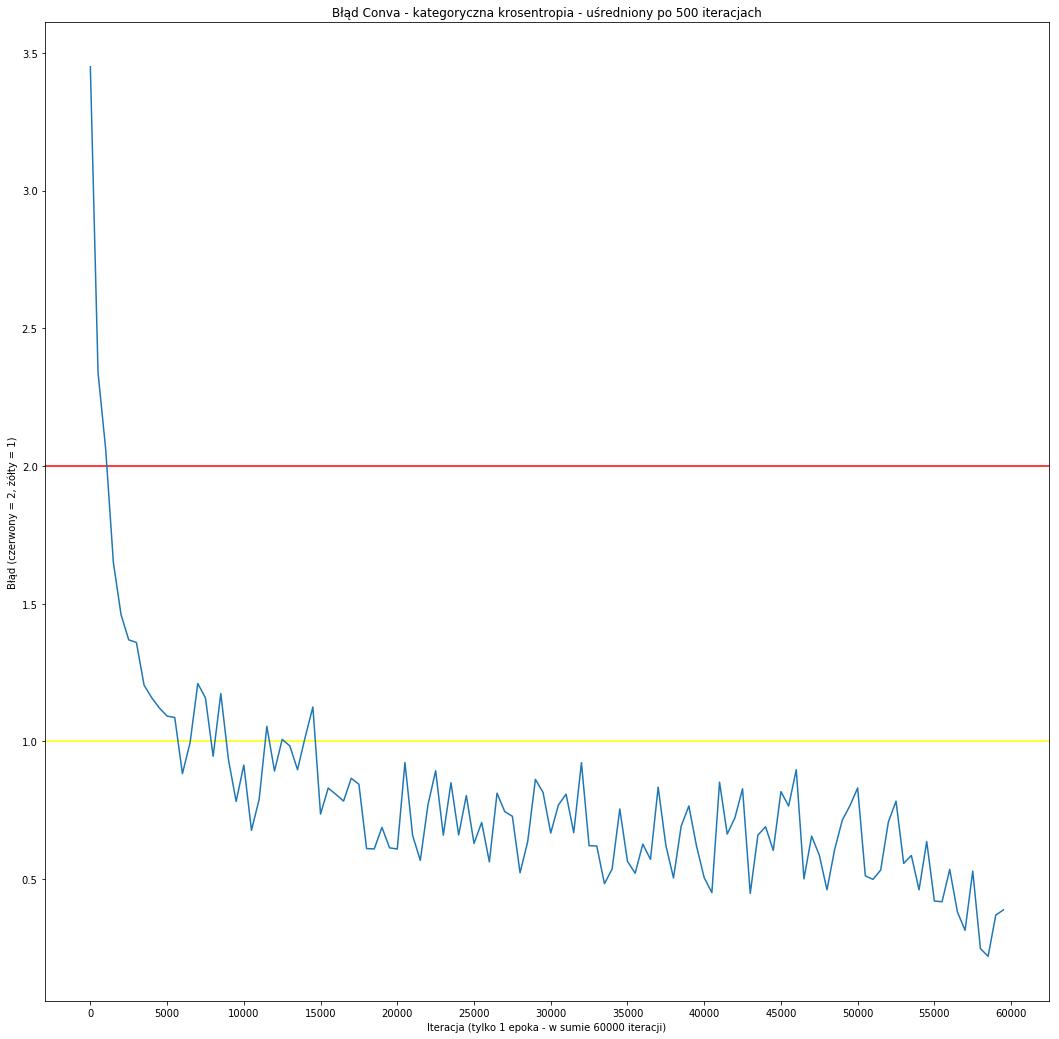

In [14]:
print(w2.shape)
fig, ax=plt.subplots(1, 1, figsize=(18,18))
dt=loopz
kgbo=500
dt2=dt//kgbo
ss=10

dkkk=[0]*dt2
for i in range(dt2):
    dkkk[i]=sum(sk[i*kgbo:(i+1)*kgbo])/kgbo

ax.set_title('Błąd Conva - kategoryczna krosentropia - uśredniony po {} iteracjach'.format(kgbo))
ax.set_xlabel('Iteracja (tylko 1 epoka - w sumie {} iteracji)'.format(loopz))
ax.set_xticklabels(range(0, loopz+1, kgbo*ss))
ax.set_xticks(range(0, loopz//kgbo+1, ss))
ax.set_ylabel('Błąd (czerwony = 2, żółty = 1)'.format(loopz))
ax.axhline(2, color='red')
ax.axhline(1, color='yellow')
ax.plot(dkkk)
plt.show()

In [13]:
num=10000
won=0

for jj in range(num):
    img=testX[jj]
    img=img/255
    img=img.reshape(img.shape[0], img.shape[1], 1)
    """img1=img.copy()
    img=np.append(img, img1, axis=2)
    img=np.append(img, img1, axis=2)"""

    m2=[0]*10
    m3=[0]*10
    m4=[0]*10
    m8=[0]*10
    #Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m2[i]=conv_forw(img, matt[i])
        m3[i]=relu(m2[i])
        m4[i], Face1=pool_forw(m3[i], (2,2))
        m8[i]=m4[i].reshape(m4[i].shape[0]*m4[i].shape[1]*m4[i].shape[2])

    """m5=[0]*10
    m6=[0]*10
    m7=[0]*10
    #Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m5[i]=conv_forw(m4[i], matt2[i]) 
        m6[i]=relu(m5[i])
        m7[i], Face2=pool_forw(m6[i], (2,2))
        m8[i]=m7[i].reshape(m7[i].shape[0]*m7[i].shape[1]*m7[i].shape[2])"""


    #Forw - 2*FC na macierzach
    kk=np.asarray(m8)
    m9=np.asmatrix(kk.reshape(kk.shape[0]*kk.shape[1], 1))
    #print(len(m9))

    s1=w1*m9
    #s2=sigmoid_forw(s1)
    s2=rell_forw(s1)
    s3=w2*s2
    s4=sigmoid_forw(s3)

    #Koszt
    dp=np.asarray([0]*10).reshape(10, 1)
    dp[testy[jj],0]=1
    der, suma=cost(dp, s4)
    mxi=0
    for i in range(10):
        if (s4[i,0]>s4[mxi,0]):
            mxi=i
    if (mxi==testy[jj]):
        won+=1    
    #print(mxi, testy[jj])
print('Skutecznosc na {} testach: {}'.format(num, won/num))

Skutecznosc na 10000 testach: 0.9162


In [32]:
##Od tego miejsca śmieci do debugu
###
###
###


k1=np.asarray([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
k1=k1.reshape(k1.shape[0], k1.shape[1], 1)
mathr=np.asarray([[1,2,3],[-1,-2,-3],[-10,10,20]])
c1=conv_forw(k1, mathr)
#c1=c1.reshape(c1.shape[0], c1.shape[1])
kgb=pool_forw(k1, (2,2))

print(kgb[1].reshape(kgb[1].shape[0], kgb[1].shape[1]))


[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 1. 0. 1.]]


In [139]:
dkk=[0]*10
for i in range(100):
    dkk[testy[i]]+=1
print(dkk)


#print(kk[3:kk.shape[0]-4,1:kk.shape[1]-2].shape)
#print(print(kk[3:kk.shape[0]-4,1:kk.shape[1]-2]))
#print(z)
#TT=(kk[3:kk.shape[0]-4,1:kk.shape[1]-2]==z)
#print(TT[TT==False])

[8, 14, 8, 11, 14, 7, 10, 15, 2, 11]


(1048, 698, 3) (7, 7)
2 2
(1050, 705, 3) (7, 7)
(150, 100)
150 100


In [17]:
mat=mymat
Y=np.ndarray((z.shape[0]*mat.shape[0], z.shape[1]*mat.shape[1]*3, z.shape[2]*2), dtype='float64')
t1=time.time()
for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        for ij in range(z.shape[2]):
            Y[i:i+1,j,ij]=1
t2=time.time()
print(t2-t1)
print(Y.shape[0]*Y.shape[1]*Y.shape[2])

7.269612789154053
29625912


In [10]:
k=[random.random() for i in range(10)]
print(k)

[0.5984270187569013, 0.9671677742926911, 0.7976401137331915, 0.053760428992956966, 0.25749371422047285, 0.16253284123891132, 0.9060344103299387, 0.2756248627348449, 0.5445703657707015, 0.39006604163079217]


In [ ]:
z=cv2.imread("E:\W3\GGHard.jpg")
#z=z/255
mymat=np.asarray([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
z=conv_forw(z, mymat)
z=relu(z)
t1=time.time()
z, dt=pool_forw(z,(7,7))
t2=time.time()
print(t2-t1)
print(dt.shape)
#z=pool(z,(7,7))

"""fig, ax=plt.subplots(1,1,figsize=(20,20))
ax.imshow(z)
ax.axis('off')
plt.show()"""

In [ ]:
def conv_forw(X, mat):
    Z=np.ndarray((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    Z=Z*0
    print(type(X))
    X=X.astype('int64')
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            Z=Z+ff
    return Z

def conv_forw2(X, mat):
    Z=np.ndarray((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    Z=Z*0
    print(type(X))
    X=X.astype('int64')    
    
    print(Z.shape[0]*Z.shape[1]*mat.shape[0]*mat.shape[0])
    xz1=mat.shape[0]
    xz2=mat.shape[1]
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            ii=0
            while (ii<xz1):
                jj=0
                while(jj<xz2):
                    Z[i,j]=1
                    jj+=1
                ii+=1
    return Z
            
B=np.asarray([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
kurl=r"E:\W3\GGHard.jpg"
kk=cv2.imread(kurl)

t1=time.time()
nightmare=conv_forw2(kk, B)
t2=time.time()
print(t2-t1)
t1=time.time()
nightmare2 = ndimage.convolve(kk.astype('int64'), B.reshape(3,3,1))
t2=time.time()
print(t2-t1)

fig, ax=plt.subplots(1,2,figsize=(22,22))
ax[0].imshow(nightmare2)
ax[0].axis('off')
ax[1].imshow(nightmare)
ax[1].axis('off')
plt.show()

In [ ]:
print(kk.shape)
print(nightmare2[1:nightmare2.shape[0]-1,1:nightmare2.shape[1]-1])
print(nightmare)

def relu(x):
    if (x<0):
        return 0
    return x

def pool_forward(X):
    Y=pd.Series([True]*X.shape[0])
    Y2=pd.Series([True]*X.shape[1])
    
    Y[Y.index%2==0]=False
    Y2[Y2.index%2==0]=False 
    KK1=X[Y][:,Y2]
    KK2=X[Y][:,~Y2]
    KK3=X[~Y][:,Y2]
    KK4=X[~Y][:,~Y2]
    
    Dt=KK1*0+1
    Exit=KK1
    Dt[Exit<KK2]=2
    Exit[Exit<KK2]=KK2[Exit<KK2]
    Dt[Exit<KK3]=3
    Exit[Exit<KK3]=KK3[Exit<KK3]
    Dt[Exit<KK4]=4
    Exit[Exit<KK4]=KK3[Exit<KK4]
    
    return (Dt, KK1)

t1=time.time()
Res, KK=pool_forward(nightmare)
t2=time.time()
print(t2-t1)

print(nightmare[:4,:4,0])

#Dodanie wersetu w 2 wymiarze
print(KK.shape)
s=[0]*KK.shape[0]*KK.shape[2]
s=np.asarray(s).reshape(KK.shape[0], 1, 3)
GG=np.append(KK, s, axis=1)
print(GG.shape)

In [98]:
n1, n2 = np.arange(5), np.arange(5)
Y=m7[0]
n1=np.arange(m7[0].shape[0])

f1=pd.Series([1]*Y.shape[0])
f2=pd.Series([1]*Y.shape[1])
f3=pd.Series([1]*Y.shape[2])

n1=np.asarray(f1[(f1.index%2)==0].index)
n2=np.asarray(f2[(f2.index%2)==1].index)
n3=np.asarray(f3.index)

m7[0][n1,n2]=13
print(m7[0][np.ix_(n1, n2,n3)].shape)
print(m7[0].shape)

(3, 3, 3)
(6, 6, 3)


In [119]:
print(math.exp(-100000))

0.0


In [71]:
print(matt)

[[[-1.80641111e-01  1.01303406e+00  5.68658521e-02]
  [-1.50180242e-01 -4.49518778e-01  2.29888229e-01]
  [-1.49464212e-01  1.79568202e-02  5.63098800e-01]]

 [[ 3.57100431e-01 -1.24985684e-01 -1.44566969e-01]
  [ 5.21873333e-01  9.49807180e-01  8.12153844e-01]
  [-1.77566089e-01 -6.69357460e-01  4.61081356e-01]]

 [[ 8.51013511e-01 -3.23042716e-01 -5.74604168e-01]
  [ 1.54445548e-01 -2.12365245e-01 -6.03171539e-01]
  [ 1.08646375e+00 -3.59921150e-01 -3.14678410e-01]]

 [[-3.09463601e-01 -8.49167675e-01  4.21892386e-01]
  [-9.78466819e-02  4.85793427e-01  4.07272130e-01]
  [-4.93156935e-01 -2.03789750e-01 -7.12313815e-02]]

 [[-8.53628217e-02 -7.04846645e-04  6.31339778e-03]
  [ 5.44888689e-01 -4.57835885e-01 -4.06130290e-01]
  [-7.09531689e-02 -4.13826322e-01  3.46471223e-01]]

 [[-3.29109786e-01  6.69617081e-01  4.80251536e-01]
  [-4.98654748e-01  5.22653924e-02 -4.02342825e-01]
  [ 3.54233047e-01 -4.11030534e-01 -4.91160409e-02]]

 [[-1.87180082e-01  8.45536081e-04  4.05606974e-02]


In [ ]:
##DIRT

#Tworzę większą tablicę zer i "wkładam" w nią X - array
def my_pad(X, a, b, c, d):    
    Y=np.zeros((X.shape[0]+b+d, X.shape[1]+a+c, X.shape[2]), dtype='float64')
    Y[b:X.shape[0]+b,a:X.shape[1]+a,:]=X
    return Y

def conv_forw(X, mat):
    Z=np.zeros((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            Z=Z+ff
    return Z

def conv_back(X, mat, Der):
    Z=np.ndarray((X.shape[0], X.shape[1], X.shape[2]), dtype='float64')
    matd=mat*0
    Z=Z*0
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*Der
            Z[i:Der.shape[0]+i,j:Der.shape[1]+j]=Z[i:Der.shape[0]+i,j:Der.shape[1]+j]+ff
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            matd[i,j]=sum(sum(sum(np.multiply(ff, Der))))
    return (Z, matd)

def relu(X):
    Y=X.copy()
    Y[Y<0]=0
    return Y

def relu_back(X, Der):
    Sd=Der.copy()
    Sd[X<0.0000001]=0
    return Sd

def pool_forw(X, mat):
    t1=(mat[0]-X.shape[0]%mat[0])%mat[0]
    t2=(mat[1]-X.shape[1]%mat[1])%mat[1]
    
    Y=my_pad(X, t2//2, t1//2, (t2//2+t2%2), t1//2+t1%2)
    silver_in_blood=np.asarray([[0]*(Y.shape[1]//mat[1])]*(Y.shape[0]//mat[0]))
    
    Exit=np.zeros(Y.shape, dtype='float64')
    Exit=Exit[:(Exit.shape[0]//mat[0]),:(Exit.shape[1]//mat[1])]
    
    Truth=np.zeros(Y.shape, dtype='int64')
    Truth2=np.zeros(Y.shape, dtype='int64')
    Pure=np.zeros(Y.shape, dtype='float64')
    
    Truth=Truth[:(Truth.shape[0]//mat[0]),:(Truth.shape[1]//mat[1])]
    Truth2=Truth2[:(Truth2.shape[0]//mat[0]),:(Truth2.shape[1]//mat[1])]
    
    for i in range(mat[0]):
        for j in range(mat[1]):
            Bleeding_One=Y[list(range(i, Y.shape[0], mat[0]))][:,list(range(j, Y.shape[1], mat[1]))]
            #Bleeding_One=Y[np.ix_(list(range(0, Y.shape[0], mat[0])),list(range(0, Y.shape[1], mat[1])))]
            
            Truth[Exit<Bleeding_One]=i
            Truth2[Exit<Bleeding_One]=j
            Exit[Exit<Bleeding_One]=Bleeding_One[Exit<Bleeding_One]
    
    for i in range(Truth.shape[0]):
        for j in range(Truth.shape[1]):
            for ij in range(Truth.shape[2]):
                Pure[i*mat[0]+Truth[i,j,ij],j*mat[1]+Truth2[i,j,ij],ij]=1
    return (Exit, Pure)

def pool_back(X, mat, dim):
    Y=np.ndarray((X.shape[0]*mat[0], X.shape[1]*mat[1], X.shape[2]), dtype='float64')
    
    for i in range(mat[0]):
        for j in range(mat[1]):
            Y[np.ix_(np.asarray(list(range(i,Y.shape[0],mat[0]))),np.asarray(list(range(j,Y.shape[1],mat[1]))))]=X
    Y=Y*dim
    return Y


def sigmoid(x):
    try:
        s=1/(1+math.exp(-x))
        return s
    except:
        return 0
    
def sigmoid_forw(v):
    return np.asmatrix(np.apply_along_axis(sigmoid, 1, v).reshape(v.shape[0], 1))

def sigmoid_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: sigmoid(x)*(1-sigmoid(x)), 1, v).reshape(v.shape[0], 1))

def rell_forw(v):
    return np.asmatrix(np.apply_along_axis(lambda x: max(0.0, x), 1, v).reshape(v.shape[0], 1))

def rell_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: np.sign(max(0.0, x)), 1, v).reshape(v.shape[0], 1))

def cost(act, pred):
    summ=0
    der=pred*0
    
    for i in range(pred.shape[0]):        
        if ((pred[i,0]==0 and act[i,0]==0) or (pred[i,0]==1 and act[i,0]==1)):
            der[i,0]=0
        else:
            if (pred[i,0]<0.000001):
                pred[i,0]=0.000001
            elif(pred[i,0]>0.99999):
                pred[i,0]=0.99999
            der[i,0]=-act[i,0]/pred[i,0]+(1-act[i,0])/(1-pred[i,0])
        
        if (pred[i,0]<0.000001):
            pred[i,0]=0.000001
        elif(pred[i,0]>0.99999):
            pred[i,0]=0.99999
        
        summ=summ-act[i,0]*math.log(pred[i,0])-(1-act[i,0])*math.log(1-pred[i,0])
        
    return (der, summ)

#ccn - learning rate, loopz - number of iterations, streetcleaner - hardcoded number of weights in first Fully connected layer
ccn=0.0002
loopz=1000
streetcleaner=1690

matt=[0]*10
matt2=[0]*10
for i in range(10):
    matt[i]=np.asarray([np.random.normal(0, 0.4) for j in range(9)]).reshape(3,3)
    matt2[i]=np.asarray([np.random.normal(0, 0.4) for j in range(9)]).reshape(3,3)

#img=cv2.imread("E:\W3\GGHard.jpg")
w1=np.asmatrix(np.asarray([np.random.normal(0, 0.4) for j in range(streetcleaner*20)]).reshape(20,streetcleaner))
#bw1=np.random.normal(0, 0.4)
w2=np.asmatrix(np.asarray([np.random.normal(0, 0.4) for j in range(10*20)]).reshape(10,20))
#bw2=np.random.normal(0, 0.4)

m2=[0]*10
m3=[0]*10
m4=[0]*10
m5=[0]*10
m6=[0]*10
m7=[0]*10
m8=[0]*10
mtb2=[0]*10
mtb3=[0]*10
mtb4=[0]*10
mtb5=[0]*10
mtb6=[0]*10
mtb7=[0]*10
mtb8=[0]*10


sk=[0]*loopz
t1=time.time()
for jj in range(loopz):
    img=trainX[jj]
    img=img/255
    img=img.reshape(img.shape[0], img.shape[1], 1)
    """img1=img.copy()
    img=np.append(img, img1, axis=2)
    img=np.append(img, img1, axis=2)"""
    
    #Forw - Konwolucja, Relu, Pooling
    
    for i in range(10):
        m2[i]=conv_forw(img, matt[i])
        m3[i]=relu(m2[i])
        m4[i], Face1=pool_forw(m3[i], (2,2))
        m8[i]=m4[i].reshape(m4[i].shape[0]*m4[i].shape[1]*m4[i].shape[2])
    
    """#Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m5[i]=conv_forw(m4[i], matt2[i]) 
        m6[i]=relu(m5[i])
        m7[i], Face2=pool_forw(m6[i], (2,2))
        m8[i]=m7[i].reshape(m7[i].shape[0]*m7[i].shape[1]*m7[i].shape[2])"""

    #Forw - 2*FC na macierzach
    kk=np.asarray(m8)
    m9=np.asmatrix(kk.reshape(kk.shape[0]*kk.shape[1], 1))
    #print(len(m9))

    s1=w1*m9#+bw1
    #s2=sigmoid_forw(s1)
    s2=rell_forw(s1)
    s3=w2*s2#+bw2
    #s4=sigmoid_forw(s3)
    s4=rell_forw(s3)
    
    #Koszt
    dp=np.asarray([0]*10).reshape(10, 1)
    dp[trainy[jj],0]=1
    der, suma=cost(dp, s4)
    sk[jj]=suma
    print(suma)
    
    #Back - 2.FC
    #dk2=np.asmatrix(np.asarray(sigmoid_back(s3))*np.asarray(der))
    dk2=np.asmatrix(np.asarray(rell_back(s3))*np.asarray(der))
    weight_delta2=dk2*s2.T
    #bw2_delta=sum(dk2)[0,0]
    dk1=w2.T*dk2

    #Back - 1.FC
    #dk1=np.asmatrix(np.asarray(sigmoid_back(s1))*np.asarray(dk1))
    dk1=np.asmatrix(np.asarray(rell_back(s1))*np.asarray(dk1))
    weight_delta1=dk1*m9.T
    #bw1_delta=sum(dk1)[0,0]
    dk0=w1.T*dk1
    

    #Back - 2*Konw, RElu, Pooling
    #dkl=np.asarray(dk0).reshape(10, m7[0].shape[0], m7[0].shape[1], m7[0].shape[2])
    dkl=np.asarray(dk0).reshape(10, m4[0].shape[0], m4[0].shape[1], m4[0].shape[2])
    
    """for i in range(10):
        mtb8[i]=pool_back(dkl[i], (2,2), Face2)
        cz=m6[i].shape
        nw=mtb8[i].shape
        mtb8[i]=mtb8[i][(nw[0]-cz[0])//2:cz[0]+(nw[0]-cz[0])//2, (nw[1]-cz[1])//2:cz[1]+(nw[1]-cz[1])//2]
        #print(m6[i].shape, mtb8[i].shape)
        mtb7[i]=relu_back(m6[i], mtb8[i])
        mtb6[i], Dr2=conv_back(m4[i], matt2[i], mtb7[i])"""
    
    for i in range(10):
        #mtb5[i]=pool_back(mtb6[i], (2,2), Face1)
        mtb5[i]=pool_back(dkl[i], (2,2), Face1)
        cz=m3[i].shape
        nw=mtb5[i].shape
        mtb5[i]=mtb5[i][(nw[0]-cz[0])//2:cz[0]+(nw[0]-cz[0])//2, (nw[1]-cz[1])//2:cz[1]+(nw[1]-cz[1])//2]
        mtb4[i]=relu_back(m3[i], mtb5[i])
        mtb3[i], Dr=conv_back(img, matt[i], mtb4[i])

    w1-=weight_delta1*ccn
    #bw1-=bw1_delta*ccn*0.1
    w2-=weight_delta2*ccn
    #bw2-=bw2_delta*ccn*0.05
    matt-=Dr*ccn
    #matt2-=Dr2*ccn
    

t2=time.time()
print(t2-t1)
print(s4)